Imports

In [1]:
import numpy as np
import pandas as pd
import pickle
from sentence_transformers import SentenceTransformer
import time
import math
import re
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the SBERT model
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

In [3]:
def create_tf_matrix(sentences):
    tf_matrix = []
    for list in sentences:
        tf_table = []
        # Determining frequency of words in the sentence
        word_freq = {}
        for word in list:
            word_freq[word] = (word_freq[word] + 1) if word in  word_freq else 1
        # Calculating tf of the words in the sentence
        for word in list:
            tf_table.append((word, math.log10(word_freq[word] + 1)))
        tf_matrix.append(tf_table)
    return tf_matrix

In [4]:
def create_idf_matrix(sentences):

    idf_matrix = []

    documents_count = len(sentences)
    total_words_corpus = []

    # Getting words in the sentence
    for list in sentences:
        total_words_corpus.append(list)

    # Determining word count table with the count of sentences which contains the word.
    word_in_docs = {}
    for list in sentences:
        for word in list:
            word_in_docs[word] = (word_in_docs[word] + 1) if word in word_in_docs else 1

    # Determining idf of the words in the sentence.
    for list in sentences:
        idf_table = []
        for word in list:
            idf_table.append((word, math.log10(documents_count / float(word_in_docs[word]))))

        idf_matrix.append(idf_table)

    return idf_matrix

In [5]:
def create_tf_idf_matrix(tf_matrix, idf_matrix):

    tf_idf_matrix = []

    for i in range(len(tf_matrix)):
        tf_idf_table = []
        tf_of_sentence_words = tf_matrix[i]
        idf_of_sentence_words = idf_matrix[i]

        for word in range(len(tf_of_sentence_words)):
            word_tf, tf_value = tf_of_sentence_words[word]
            word_idf, idf_value = idf_of_sentence_words[word]
            tf_idf_table.append((word_tf, tf_value * idf_value))

        tf_idf_matrix.append(tf_idf_table)

    return tf_idf_matrix

In [6]:
def calculate_sentence_scores(tf_idf_matrix, df_train):
    df_train["tf_idf_score"] = 0
    for sentence in range(len(tf_idf_matrix)):
        sum_of_tf_idf = 0
        len_of_sentence = len(tf_idf_matrix[sentence])
        for i in range(len_of_sentence):
            word, value = tf_idf_matrix[sentence][i]
            sum_of_tf_idf += value
        df_train["tf_idf_score"][sentence] = sum_of_tf_idf/len_of_sentence

    return df_train

In [7]:
def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm_vector1 = np.linalg.norm(vector1)
    norm_vector2 = np.linalg.norm(vector2)
    similarity = dot_product / (norm_vector1 * norm_vector2)
    return similarity

In [8]:
def dimensionality_reduction_with_clustering(X_data, y_data, tf_idf_matrix):
    similarity_threshold = 0.65

    embeddings = []
    y_train_reduced = []

    for i in range(len(X_data)):
        flag = 0
        for j in range(i+1, len(X_data)):
            sim = cosine_similarity(X_data[i], X_data[j])
            if sim >= similarity_threshold:
                if tf_idf_matrix[i] >= tf_idf_matrix[j] and flag == 0:
                    embeddings.append(X_data[i])
                    y_train_reduced.append(y_data[i])
                    flag = 1
                elif tf_idf_matrix[i] < tf_idf_matrix[j] and flag == 0:
                    embeddings.append(X_data[j])
                    y_train_reduced.append(y_data[j])
    return embeddings, y_train_reduced




In [9]:
baseline_results = {}
def svm_classification(baseline_results, X_train, y_train, X_dev, y_dev, kernels, suffix, verbose):
    for kernel in kernels:
        beg = time.time()  
        clf = SVC(kernel=kernel)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_dev)
        end = time.time()
        baseline_results[f'SVM-{kernel} {suffix}'] = classification_report(y_dev, y_pred, output_dict=True)
        baseline_results[f'SVM-{kernel} {suffix}']['infer_time'] = end-beg
        if verbose:
            print(f"SVM with kernel: {kernel}", end='\t')
            print(clf.score(X_dev, y_dev))

In [10]:
def mlp_classification(baseline_results, X_train, y_train, X_dev, y_dev, layers, suffix, verbose):
    for layer in layers:
        beg = time.time()
        clf = MLPClassifier(hidden_layer_sizes=layer, max_iter=3000)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_dev)
        end = time.time()
        baseline_results[f'MLP-{layer} {suffix}'] = classification_report(y_dev, y_pred, output_dict=True)
        baseline_results[f'MLP-{layer} {suffix}']['infer_time'] = end-beg
        
        if verbose:
            print(f"MLP with layers: {layer}", end='\t')
            print(clf.score(X_dev, y_dev))

In [11]:
def random_forest_classification(baseline_results, X_train, y_train, X_dev, y_dev, n_estimators, suffix, verbose):
    for n in n_estimators:
        beg = time.time()
        clf = RandomForestClassifier(n_estimators=n)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_dev)
        end = time.time()
        baseline_results[f'RandomForest-{n} {suffix}'] = classification_report(y_dev, y_pred, output_dict=True)
        baseline_results[f'RandomForest-{n} {suffix}']['infer_time'] = end-beg
        
        if verbose:
            print(f"Random Forest with n_estimators: {n}", end='\t')
            print(clf.score(X_dev, y_dev))

In [12]:
def knn_classification(baseline_results, X_train, y_train, X_dev, y_dev, n_neighbors, suffix, verbose):
    for n in n_neighbors:
        beg = time.time()
        clf = KNeighborsClassifier(n_neighbors=n)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_dev)
        end = time.time()
        baseline_results[f'KNN-{n} {suffix}'] = classification_report(y_dev, y_pred, output_dict=True)
        baseline_results[f'KNN-{n} {suffix}']['infer_time'] = end-beg

        if verbose:
            print(f"KNN with n_neighbors: {n}", end='\t')
            print(clf.score(X_dev, y_dev))

In [13]:
def run_classifiers(X_train, y_train, X_dev, y_dev, suffix='', verbose=False, results=None, **kwargs):
    if results is None:
        results = {}
    
    if verbose:
        print('Classifier\tAccuracy')
    
    svm_kernels = kwargs.get('svm_kernels', ['linear', 'poly', 'rbf', 'sigmoid'])
    svm_classification(results, X_train, y_train, X_dev, y_dev, svm_kernels, suffix, verbose)

    layers = kwargs.get('mlp_layers', [(100,), (100, 100), (200, 100), (100, 50), (200, 100, 50)])
    mlp_classification(results, X_train, y_train, X_dev, y_dev, layers, suffix, verbose)

    n_estimators = kwargs.get('rf_n_estimators', [10, 50, 100, 200, 500])
    random_forest_classification(results, X_train, y_train, X_dev, y_dev, n_estimators, suffix, verbose)

    n_neighbors = kwargs.get('knn_n_neighbors', [10, 20, 50, 100, 200, 500])
    knn_classification(results, X_train, y_train, X_dev, y_dev, n_neighbors, suffix, verbose)

    return results

In [14]:
configurations = {
    'svm_kernels': ['rbf'],
    'mlp_layers': [(200, 100)],
    'rf_n_estimators': [100],
    'knn_n_neighbors': [50],
}

In [15]:
# plot the best results for each classifier


def plot_results(baseline_results, metric, threshold=-1, figsize=(10, 5), title='Baseline Results'):
    plt.rcParams['figure.dpi'] = 300
    sorted_results = sorted([(k, v['macro avg'][metric]) for k, v in baseline_results.items()], key=lambda x: x[1], reverse=True)
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.xlabel(metric)
    plt.ylabel("Classifier")
    sns.barplot(x=[x[1] for x in sorted_results if x[1] > threshold], y=[x[0] for x in sorted_results if x[1] > threshold]) 
    plt.xlim(0, min(max([x[1] for x in sorted_results])+0.07, 1))
    
    # put the scores on the bars
    for i, v in enumerate([x[1] for x in sorted_results]):
        if v > threshold:
            # set fonr size
            plt.text(v, i + .26, f'{v:.3f}', color='black', rotation=-90, fontsize=8)

def plot_sizes(sizes, title, xlabel, figsize=(10, 5), is_ratio=False):
    # set dpi
    plt.rcParams['figure.dpi'] = 300
    sorted_sizes = sorted([(k, v) for k, v in sizes.items()], key=lambda x: x[1], reverse=True)
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Method")

    if is_ratio:
        sns.barplot(x=[x[1] for x in sorted_sizes], y=[x[0] for x in sorted_sizes])
        plt.xlim(0, max([x[1] for x in sorted_sizes])+10)
        # for i, v in enumerate([x[1] for x in sorted_sizes]):
        #     plt.text(v, i + .25, f'{v:.2f}', color='black')
    else:
        sns.barplot(x=[x[1]/(1024*1024) for x in sorted_sizes], y=[x[0] for x in sorted_sizes])
        plt.xlim(0, 10)
        for i, v in enumerate([x[1] for x in sorted_sizes]):
            plt.text(v/(1024*1024), i + .25, f'{v/(1024*1024):.2f} MB', color='black')


    plt.tight_layout()

def plot_inference_time(inference_times, title, xlabel, figsize=(10, 5)):
    plt.rcParams['figure.dpi'] = 300
    sorted_inference_times = sorted([(k, v['infer_time']) for k, v in inference_times.items()], key=lambda x: x[1], reverse=True)
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Classifier")
    # vertical barplot

    sns.barplot(x=[x[1] for x in sorted_inference_times], y=[x[0] for x in sorted_inference_times])

    
    plt.xlim(0, 6)
    for i, v in enumerate([x[1] for x in sorted_inference_times]):
        plt.text(v, i + .25, f'{v:.2f} s', color='black')

    plt.tight_layout()


***Check That Lab Dataset***

Load Data

In [16]:
df = pd.read_table('datasets/CheckThat_Lab/train_ml.tsv')
df = df.sample(n=df.shape[0], random_state=2000, replace=False).reset_index(drop=True)
df_train, df_dev = np.split(df, [int(.9*len(df))])

df_test = pd.read_table('datasets/CheckThat_Lab/test_ml.tsv')
df_test = df_test.sample(n=df_test.shape[0], random_state=2000, replace=False).reset_index(drop=True)

Generate SBERT embeddings

In [17]:
# X_train = model.encode(list(df_train.sentence))
# X_dev = model.encode(list(df_dev.sentence))
# X_test = model.encode(list(df_test.sentence))

# y_train = df_train["label"]
# y_dev = df_dev["label"]

In [18]:
# # save the embedding results
# pickle.dump(X_train, open("datasets/CheckThat_Lab/embeddings/train_embeddings_originals.p","wb" ))
# pickle.dump(X_dev, open("datasets/CheckThat_Lab/embeddings/dev_embeddings_originals.p", "wb"))
# pickle.dump(X_test, open("datasets/CheckThat_Lab/embeddings/test_embeddings_originals.p", "wb"))

# # save the labels
# pickle.dump(y_train, open("datasets/CheckThat_Lab/embeddings/train_labels_originals.p", "wb"))
# pickle.dump(y_dev, open("datasets/CheckThat_Lab/embeddings/dev_labels_originals.p", "wb"))

In [19]:
# load the embeddings
X_train = pickle.load(open("datasets/CheckThat_Lab/embeddings/train_embeddings_originals.p", "rb"))
X_dev = pickle.load(open("datasets/CheckThat_Lab/embeddings/dev_embeddings_originals.p", "rb"))
X_test = pickle.load(open("datasets/CheckThat_Lab/embeddings/test_embeddings_originals.p", "rb"))

# load the labels
y_train = pickle.load(open("datasets/CheckThat_Lab/embeddings/train_labels_originals.p", "rb"))
y_dev = pickle.load(open("datasets/CheckThat_Lab/embeddings/dev_labels_originals.p", "rb"))

Calculate TF-IDF Score

In [20]:
#Tokenize each senetence
df_train["list_of_words"] = 0

for i in range(len(df_train['sentence'])):
    sentence = df["sentence"][i].lower()
    sentence = re.sub(r'[^\w\s]', '', sentence)
 
    result = sentence.split()
    df_train["list_of_words"][i] = result
    

C:\Users\HP\AppData\Local\Temp\ipykernel_32168\3761323428.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["list_of_words"][i] = result


In [21]:
tf_matrix = create_tf_matrix(df_train["list_of_words"])
idf_matrix = create_idf_matrix(df_train["list_of_words"])

tf_idf_matrix = create_tf_idf_matrix(tf_matrix, idf_matrix)

In [22]:
df_train = calculate_sentence_scores(tf_idf_matrix, df_train)

C:\Users\HP\AppData\Local\Temp\ipykernel_32168\1346757543.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["tf_idf_score"][sentence] = sum_of_tf_idf/len_of_sentence


Cluster Embeddings on Similarity and Dimensionality Reduction

In [23]:
embeddings, y_train_reduced = dimensionality_reduction_with_clustering(X_train, y_train, tf_idf_matrix)

X_train_reduced = np.array(embeddings)
y_train_reduced = np.array(y_train_reduced)

Classification

In [24]:
proposed_results= {}
run_classifiers(X_train_reduced, y_train_reduced, X_dev, y_dev, results=proposed_results, suffix=f'Approach3-rRF', **configurations)

{'SVM-rbf Approach3-rRF': {'OBJ': {'precision': 0.765625,
   'recall': 0.8868778280542986,
   'f1-score': 0.8218029350104821,
   'support': 442},
  'SUBJ': {'precision': 0.6688741721854304,
   'recall': 0.45701357466063347,
   'f1-score': 0.543010752688172,
   'support': 221},
  'accuracy': 0.7435897435897436,
  'macro avg': {'precision': 0.7172495860927153,
   'recall': 0.671945701357466,
   'f1-score': 0.682406843849327,
   'support': 663},
  'weighted avg': {'precision': 0.7333747240618101,
   'recall': 0.7435897435897436,
   'f1-score': 0.728872207569712,
   'support': 663},
  'infer_time': 0.8783104419708252},
 'MLP-(200, 100) Approach3-rRF': {'OBJ': {'precision': 0.7830802603036876,
   'recall': 0.8167420814479638,
   'f1-score': 0.7995570321151716,
   'support': 442},
  'SUBJ': {'precision': 0.599009900990099,
   'recall': 0.5475113122171946,
   'f1-score': 0.5721040189125297,
   'support': 221},
  'accuracy': 0.726998491704374,
  'macro avg': {'precision': 0.6910450806468933,
 

Plot Results

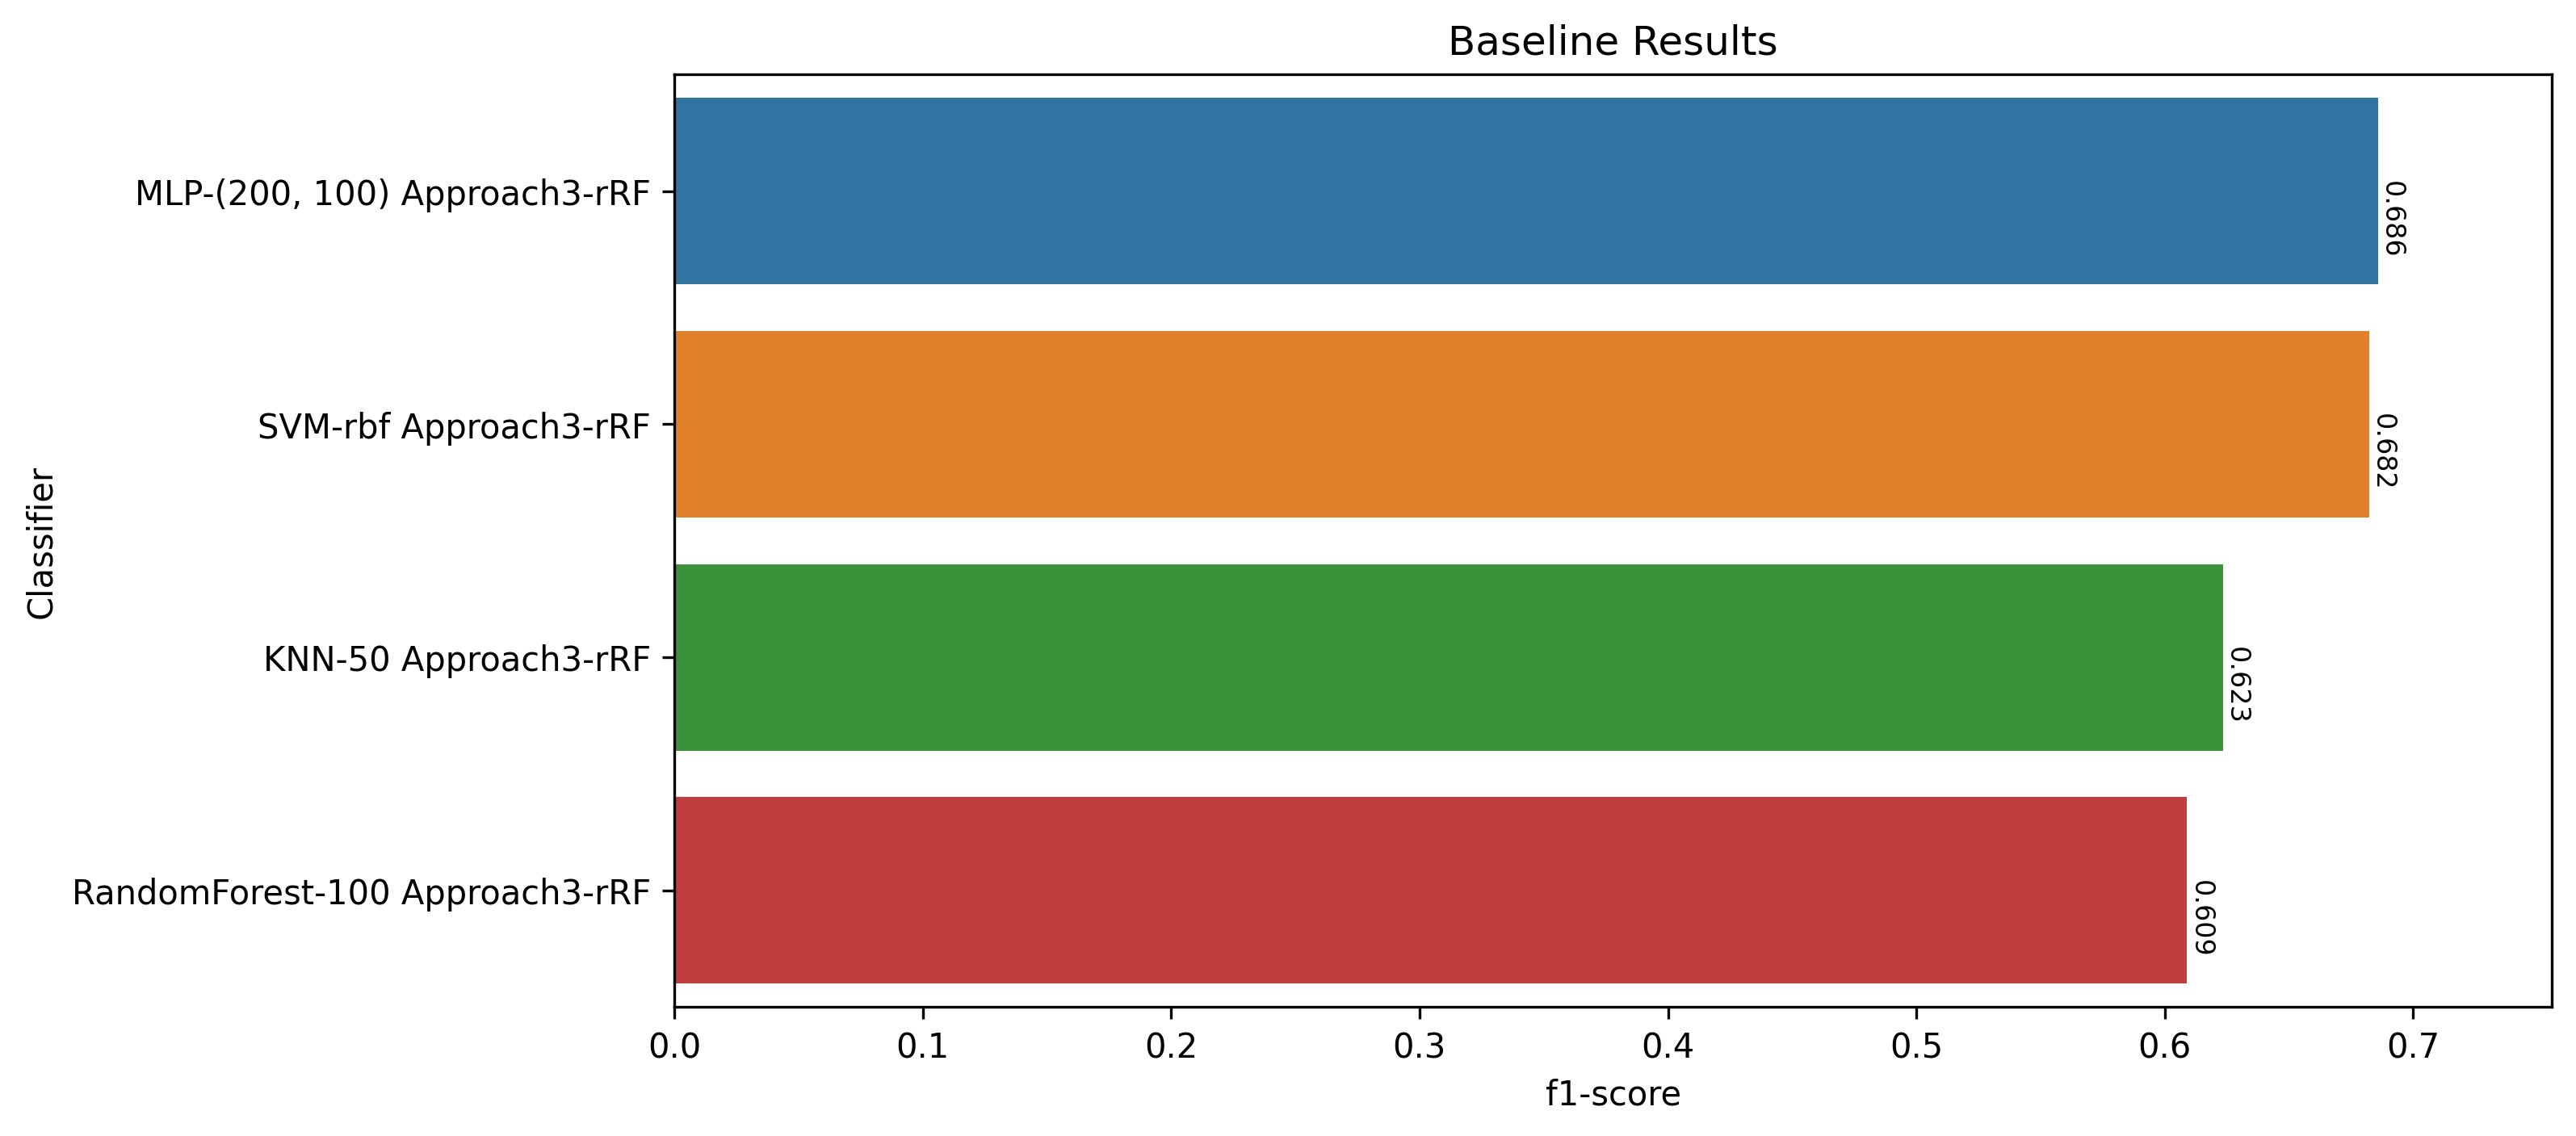

In [25]:
plot_results(proposed_results, 'f1-score')

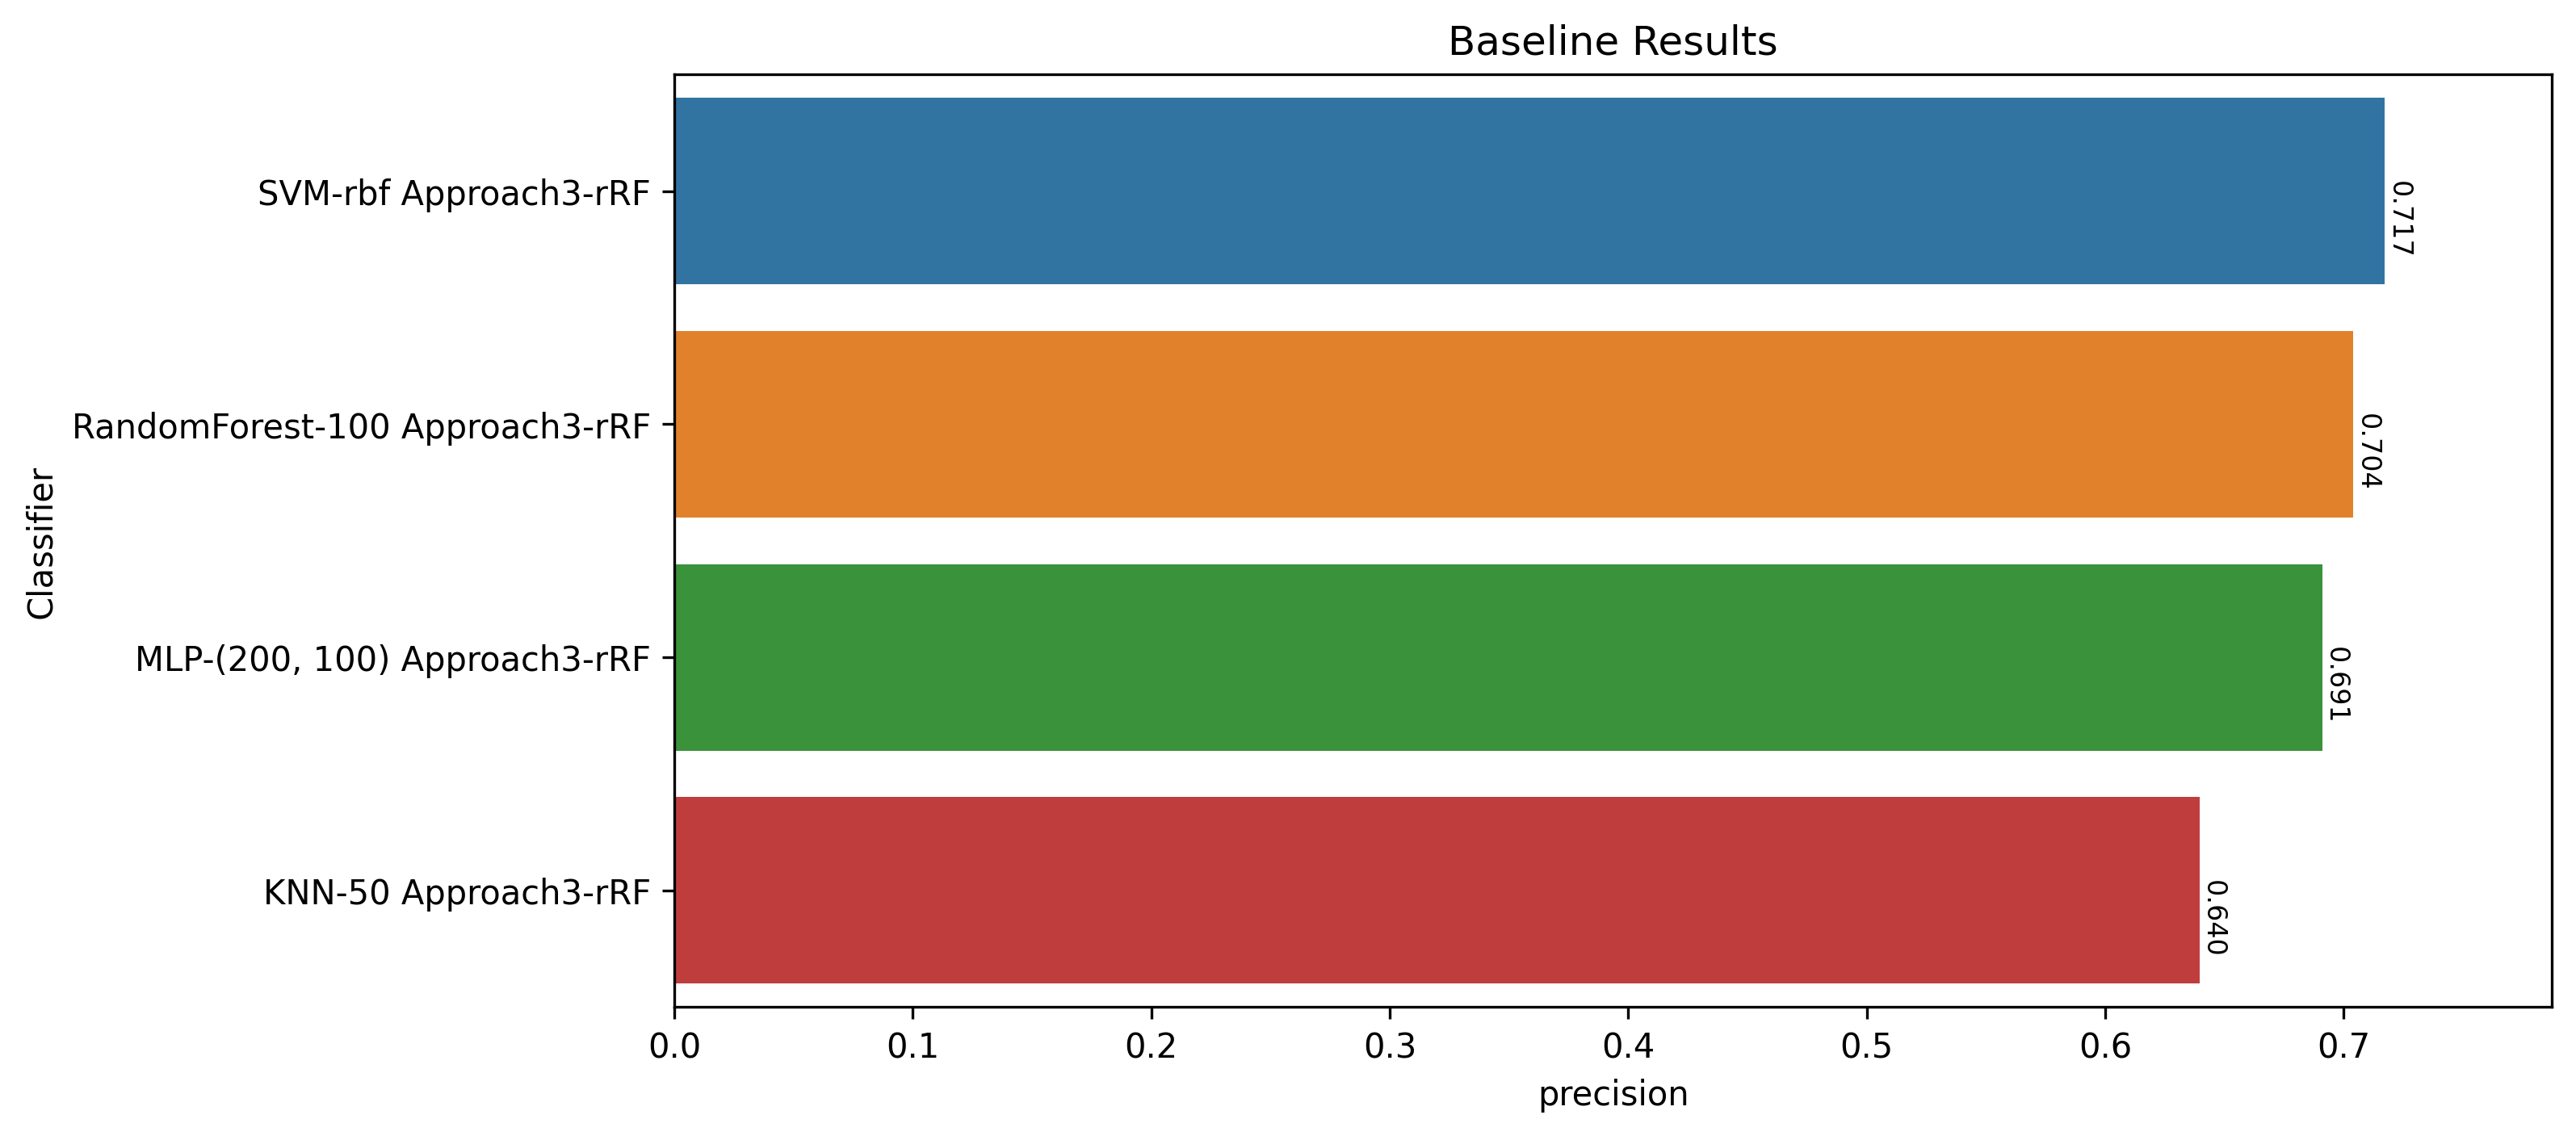

In [26]:
plot_results(proposed_results, 'precision')

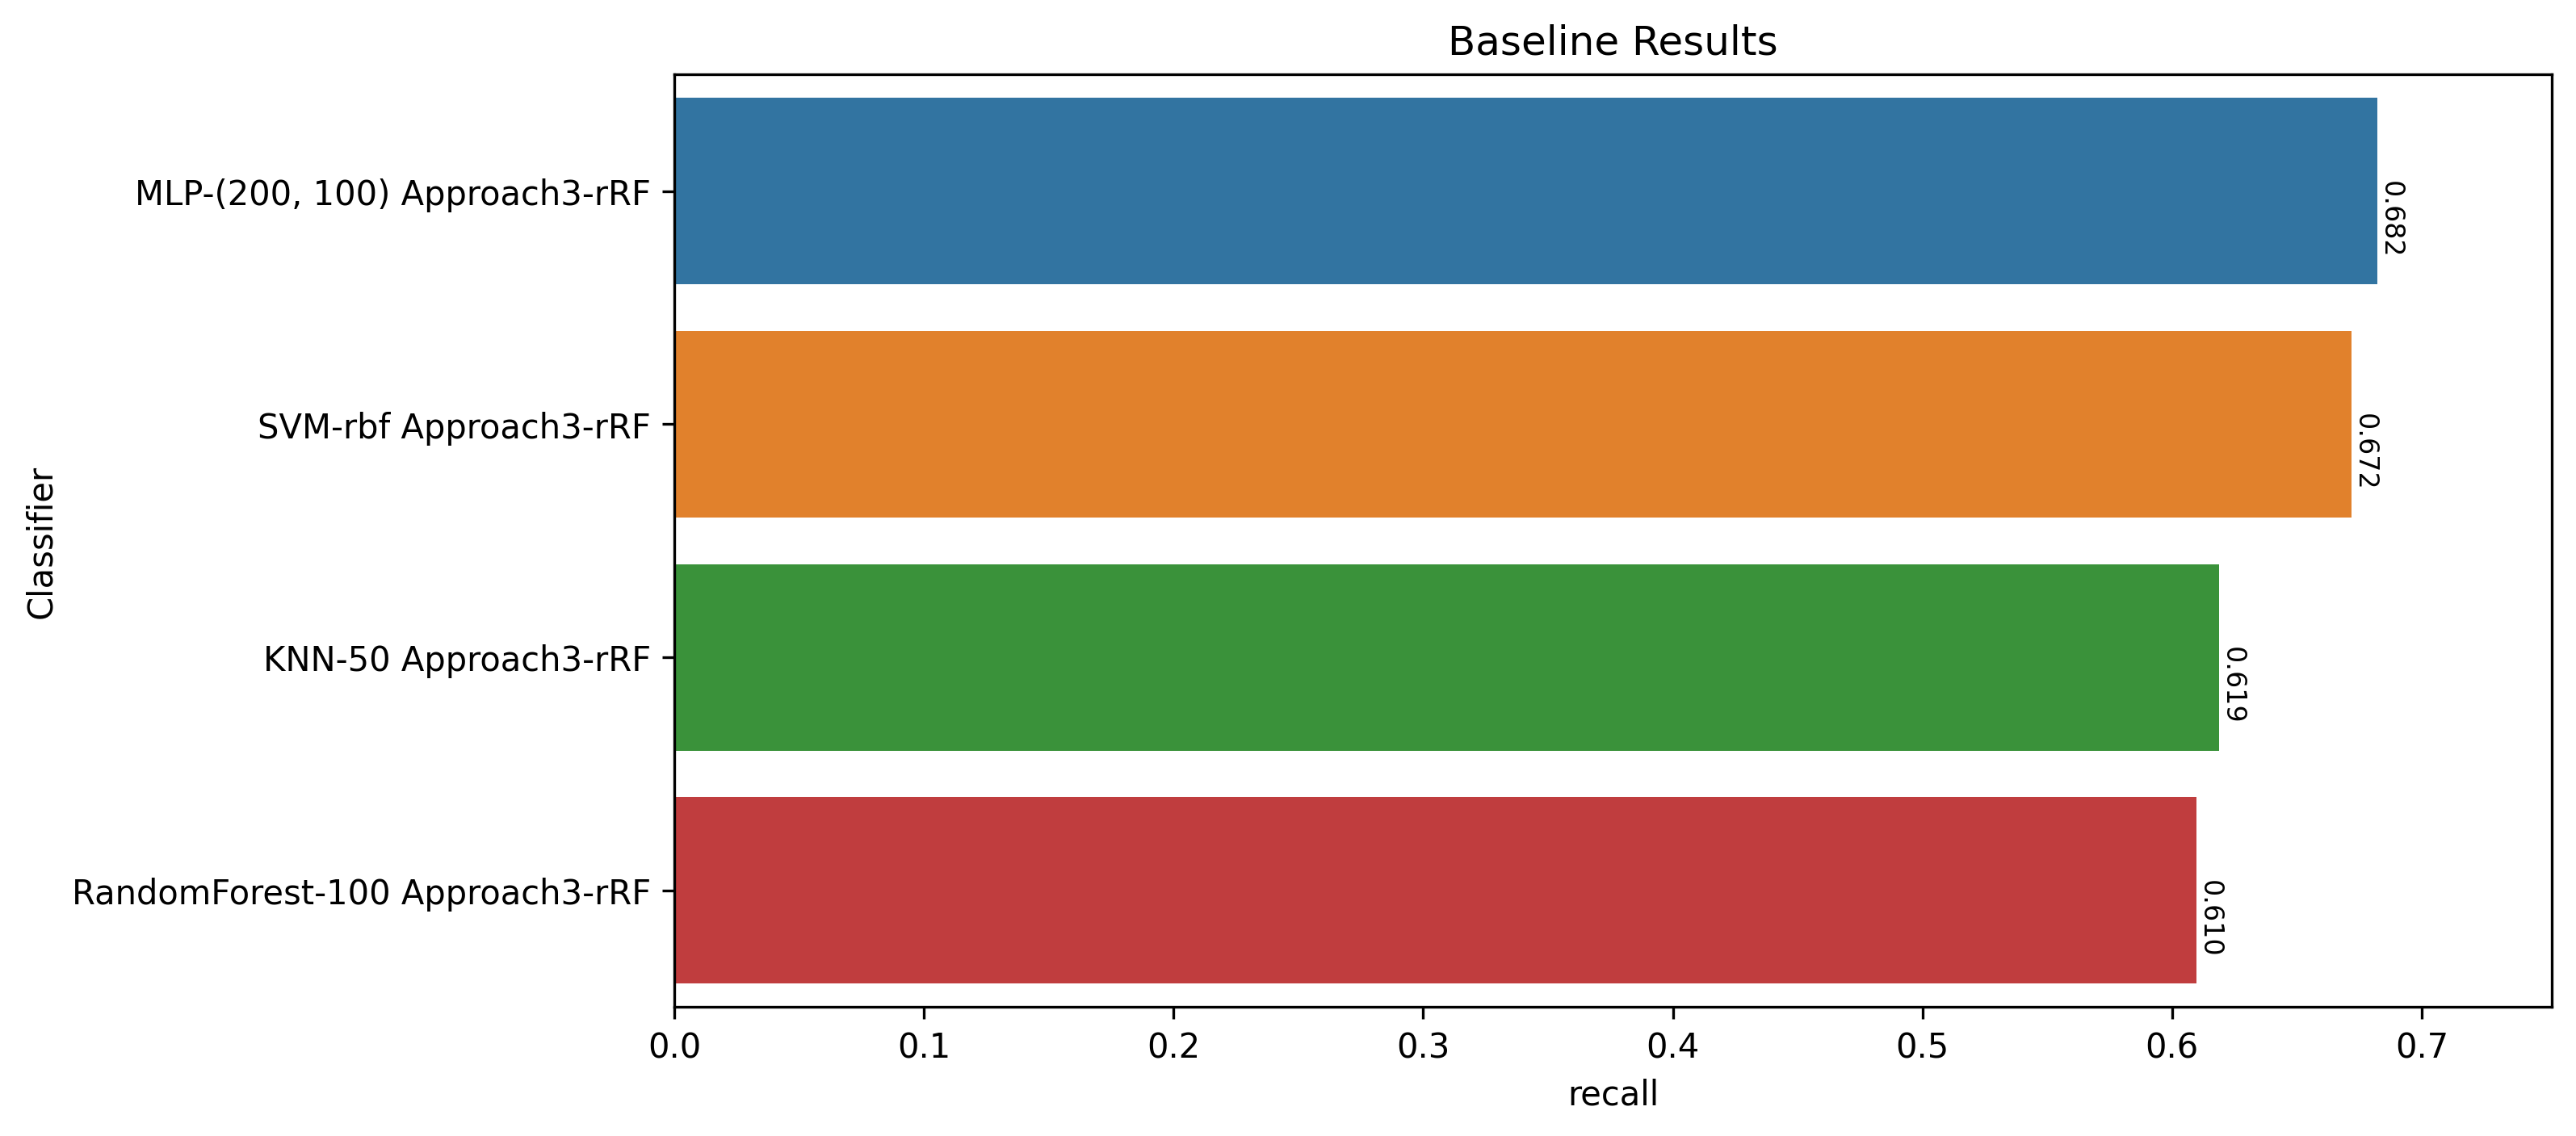

In [27]:
plot_results(proposed_results, 'recall')

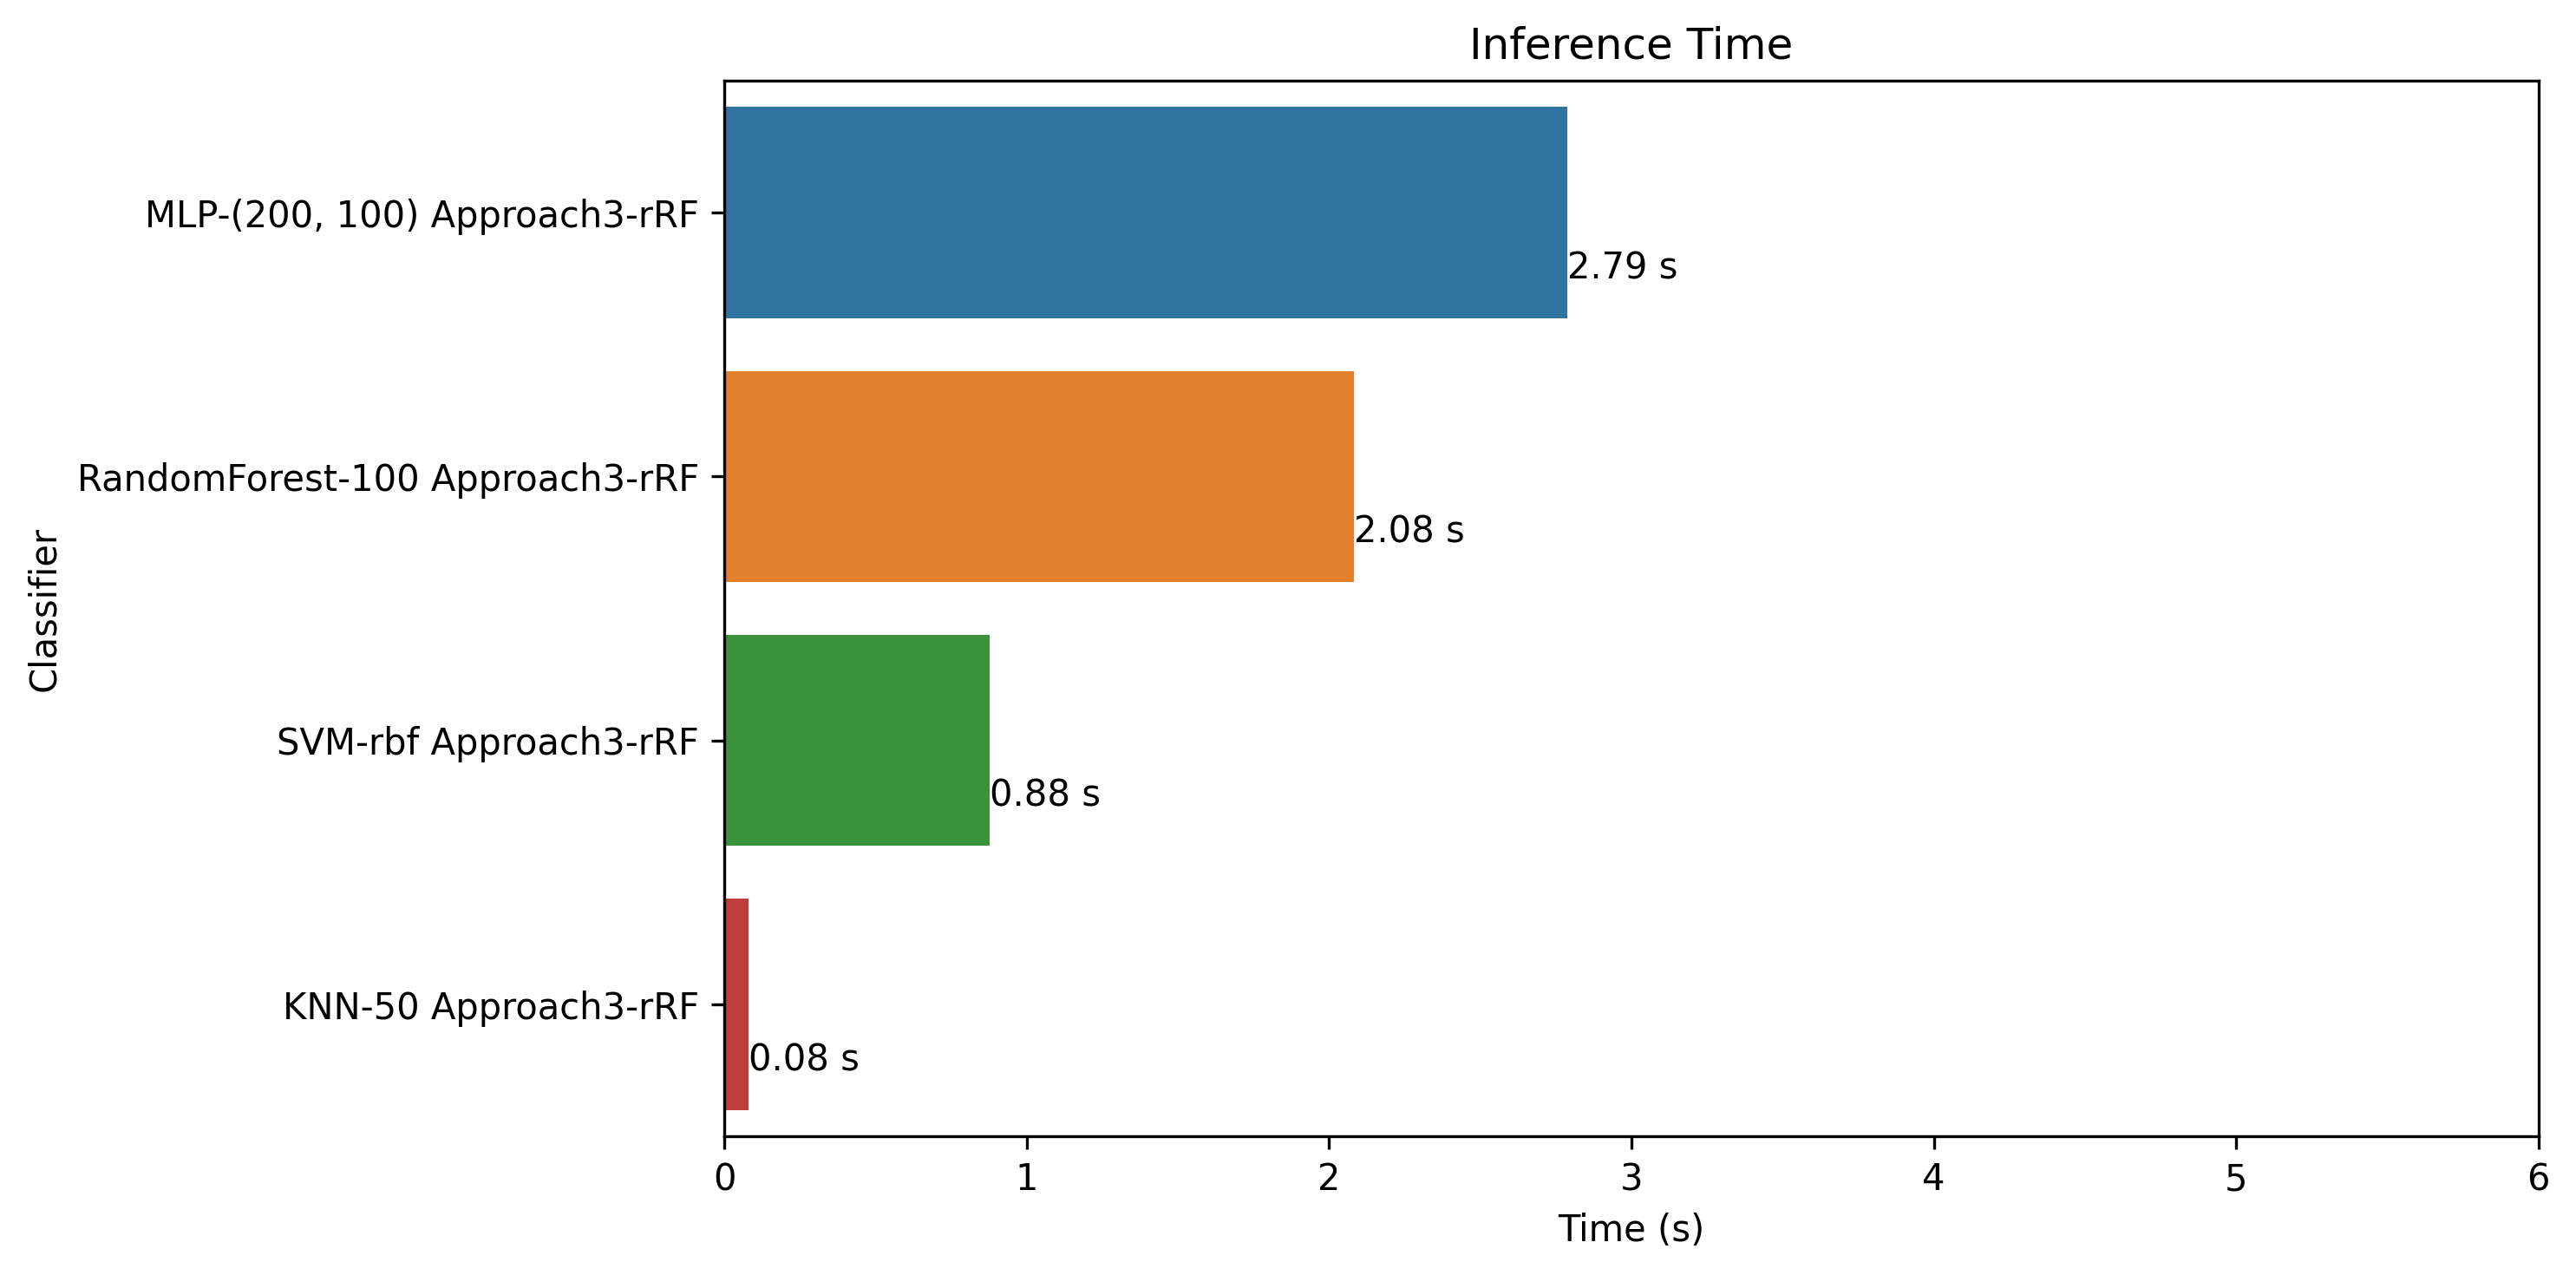

In [28]:
plot_inference_time(proposed_results, 'Inference Time', 'Time (s)')

In [29]:
memory = {}
memory["CheckThatLab"] = X_train_reduced.nbytes

In [30]:
with open("proposed_results_CheckThatLab.pkl", "wb") as pickle_file:
    pickle.dump(proposed_results, pickle_file)


***FEVER DATASET***

In [31]:
df = pd.read_csv('datasets/FEVER/Train.csv')
df.rename(columns={'claim': 'sentence'}, inplace=True)
df = df.sample(n=df.shape[0], random_state=2000, replace=False).reset_index(drop=True)
df_train, df_dev = np.split(df, [int(.9*len(df))])

df_test = pd.read_csv('datasets/FEVER/Test.csv')
df_test.rename(columns={'claim': 'sentence'}, inplace=True)
df_test = df_test.sample(n=df_test.shape[0], random_state=2000, replace=False).reset_index(drop=True)

Generate SBERT embeddings

In [32]:
# X_train = model.encode(list(df_train.sentence))
# X_dev = model.encode(list(df_dev.sentence))
# X_test = model.encode(list(df_test.sentence))

# y_train = df_train["label"]
# y_dev = df_dev["label"]

In [33]:
# # save the embedding results
# pickle.dump(X_train, open("datasets/FEVER/embeddings/SBERT/train_embeddings_originals.p","wb" ))
# pickle.dump(X_dev, open("datasets/FEVER/embeddings/SBERT/dev_embeddings_originals.p", "wb"))
# pickle.dump(X_test, open("datasets/FEVER/embeddings/SBERT/test_embeddings_originals.p", "wb"))

# # save the labels
# pickle.dump(y_train, open("datasets/FEVER/embeddings/SBERT/train_labels_originals.p", "wb"))
# pickle.dump(y_dev, open("datasets/FEVER/embeddings/SBERT/dev_labels_originals.p", "wb"))

In [34]:
# load the embeddings
X_train = pickle.load(open("datasets/FEVER/embeddings/SBERT/train_embeddings_originals.p", "rb"))
X_dev = pickle.load(open("datasets/FEVER/embeddings/SBERT/dev_embeddings_originals.p", "rb"))
X_test = pickle.load(open("datasets/FEVER/embeddings/SBERT/test_embeddings_originals.p", "rb"))

# load the labels
y_train = pickle.load(open("datasets/FEVER/embeddings/SBERT/train_labels_originals.p", "rb"))
y_dev = pickle.load(open("datasets/FEVER/embeddings/SBERT/dev_labels_originals.p", "rb"))

Calculate TF-IDF Score

In [35]:

#Tokenize each senetence
df_train["list_of_words"] = 0

for i in range(len(df_train['sentence'])):
    sentence = df["sentence"][i].lower()
    sentence = re.sub(r'[^\w\s]', '', sentence)
 
    result = sentence.split()
    df_train["list_of_words"][i] = result
    


C:\Users\HP\AppData\Local\Temp\ipykernel_32168\493725891.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["list_of_words"][i] = result


In [36]:

tf_matrix = create_tf_matrix(df_train["list_of_words"])
idf_matrix = create_idf_matrix(df_train["list_of_words"])

tf_idf_matrix = create_tf_idf_matrix(tf_matrix, idf_matrix)
df_train = calculate_sentence_scores(tf_idf_matrix, df_train)


C:\Users\HP\AppData\Local\Temp\ipykernel_32168\1346757543.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["tf_idf_score"][sentence] = sum_of_tf_idf/len_of_sentence


Cluster Embeddings on Similarity and Dimensionality Reduction


In [37]:
embeddings, y_train_reduced = dimensionality_reduction_with_clustering(X_train, y_train, tf_idf_matrix)

X_train_reduced = np.array(embeddings)
y_train_reduced = np.array(y_train_reduced)

Classification

In [38]:
proposed_results= {}
run_classifiers(X_train_reduced, y_train_reduced, X_dev, y_dev, results=proposed_results, suffix=f'Approach3-rRF', **configurations)

{'SVM-rbf Approach3-rRF': {'NOT ENOUGH INFO': {'precision': 0.4690265486725664,
   'recall': 0.3419354838709677,
   'f1-score': 0.3955223880597015,
   'support': 155},
  'REFUTES': {'precision': 0.625,
   'recall': 0.4885057471264368,
   'f1-score': 0.5483870967741936,
   'support': 174},
  'SUPPORTS': {'precision': 0.43824701195219123,
   'recall': 0.6432748538011696,
   'f1-score': 0.5213270142180094,
   'support': 171},
  'accuracy': 0.496,
  'macro avg': {'precision': 0.5107578535415859,
   'recall': 0.491238694932858,
   'f1-score': 0.4884121663506349,
   'support': 500},
  'weighted avg': {'precision': 0.512778708176145,
   'recall': 0.496,
   'f1-score': 0.49174448883848604,
   'support': 500},
  'infer_time': 4.0554039478302},
 'MLP-(200, 100) Approach3-rRF': {'NOT ENOUGH INFO': {'precision': 0.4418604651162791,
   'recall': 0.36774193548387096,
   'f1-score': 0.4014084507042253,
   'support': 155},
  'REFUTES': {'precision': 0.5944055944055944,
   'recall': 0.4885057471264368,

Plot Results

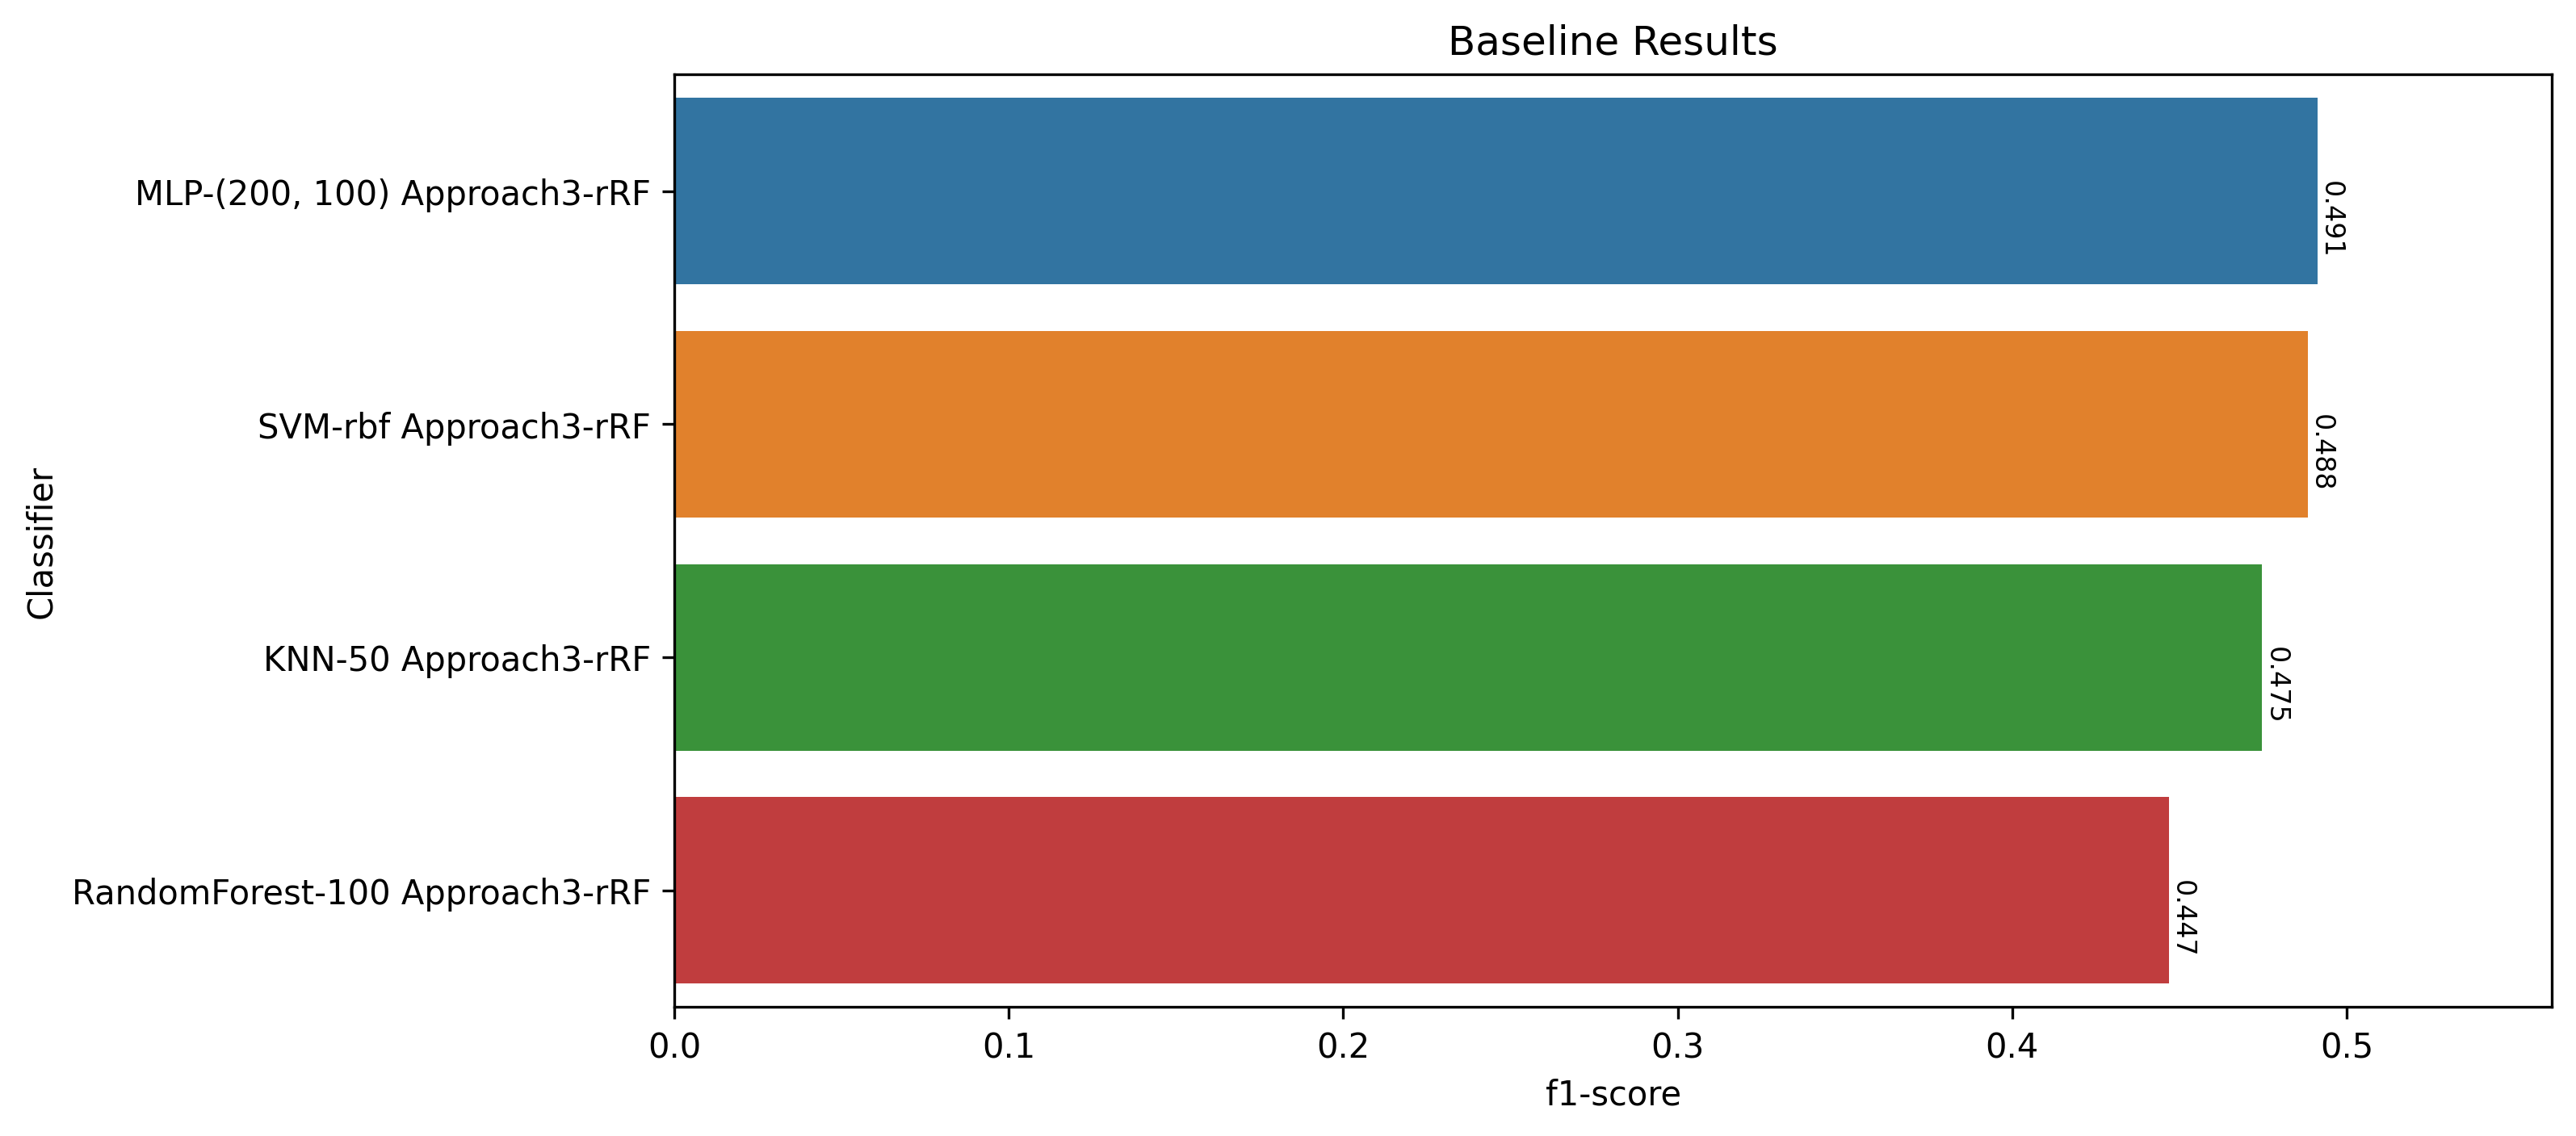

In [39]:
plot_results(proposed_results, 'f1-score')

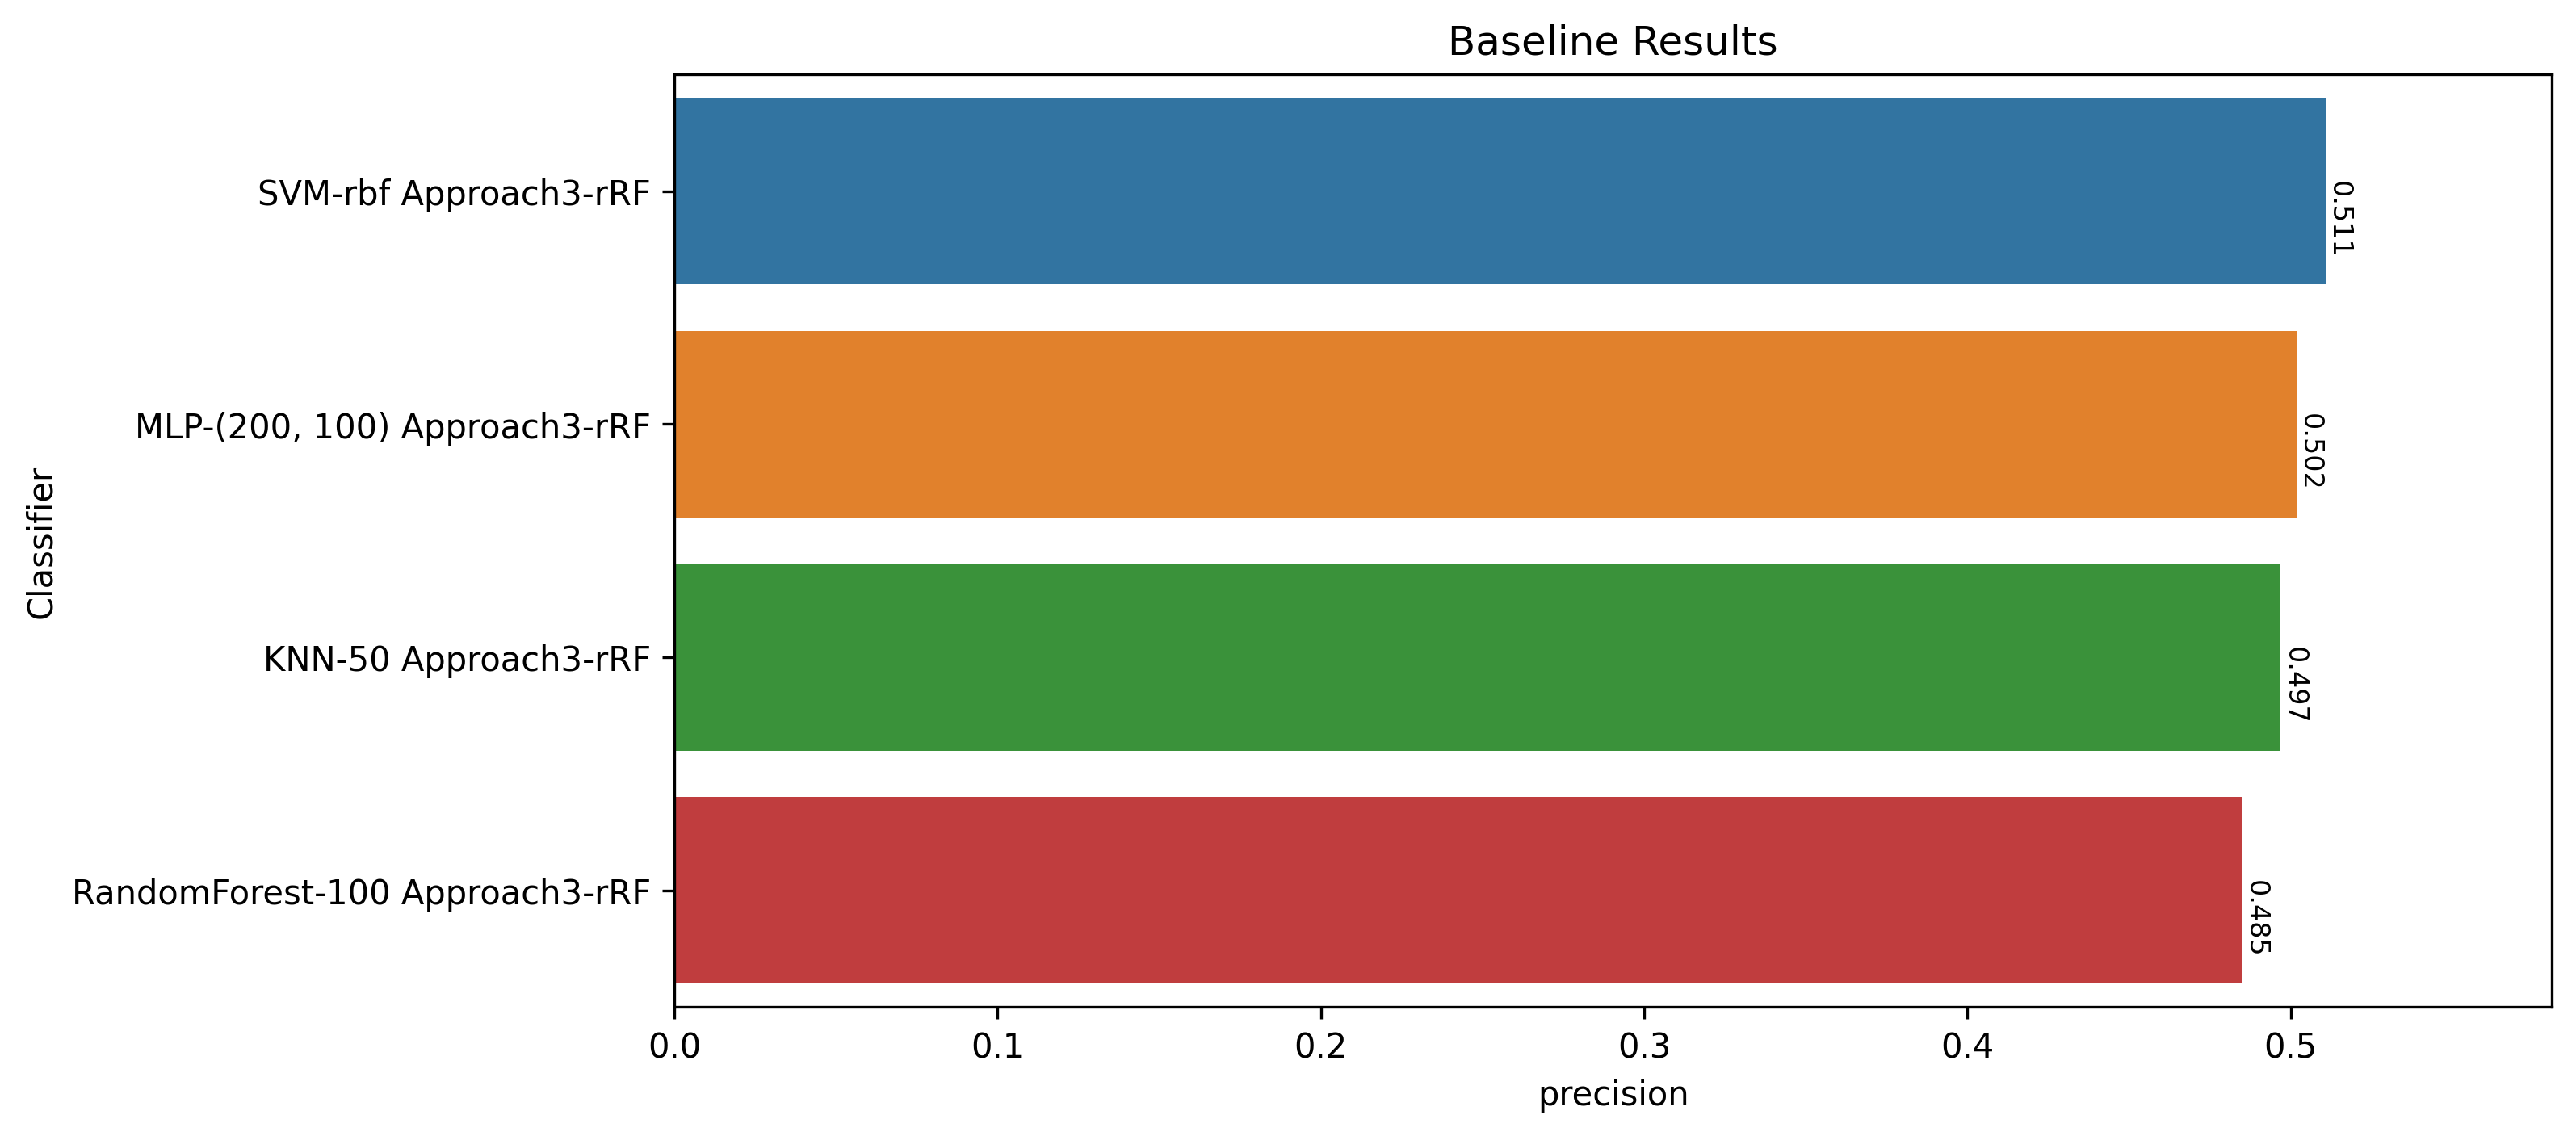

In [40]:
plot_results(proposed_results, 'precision')

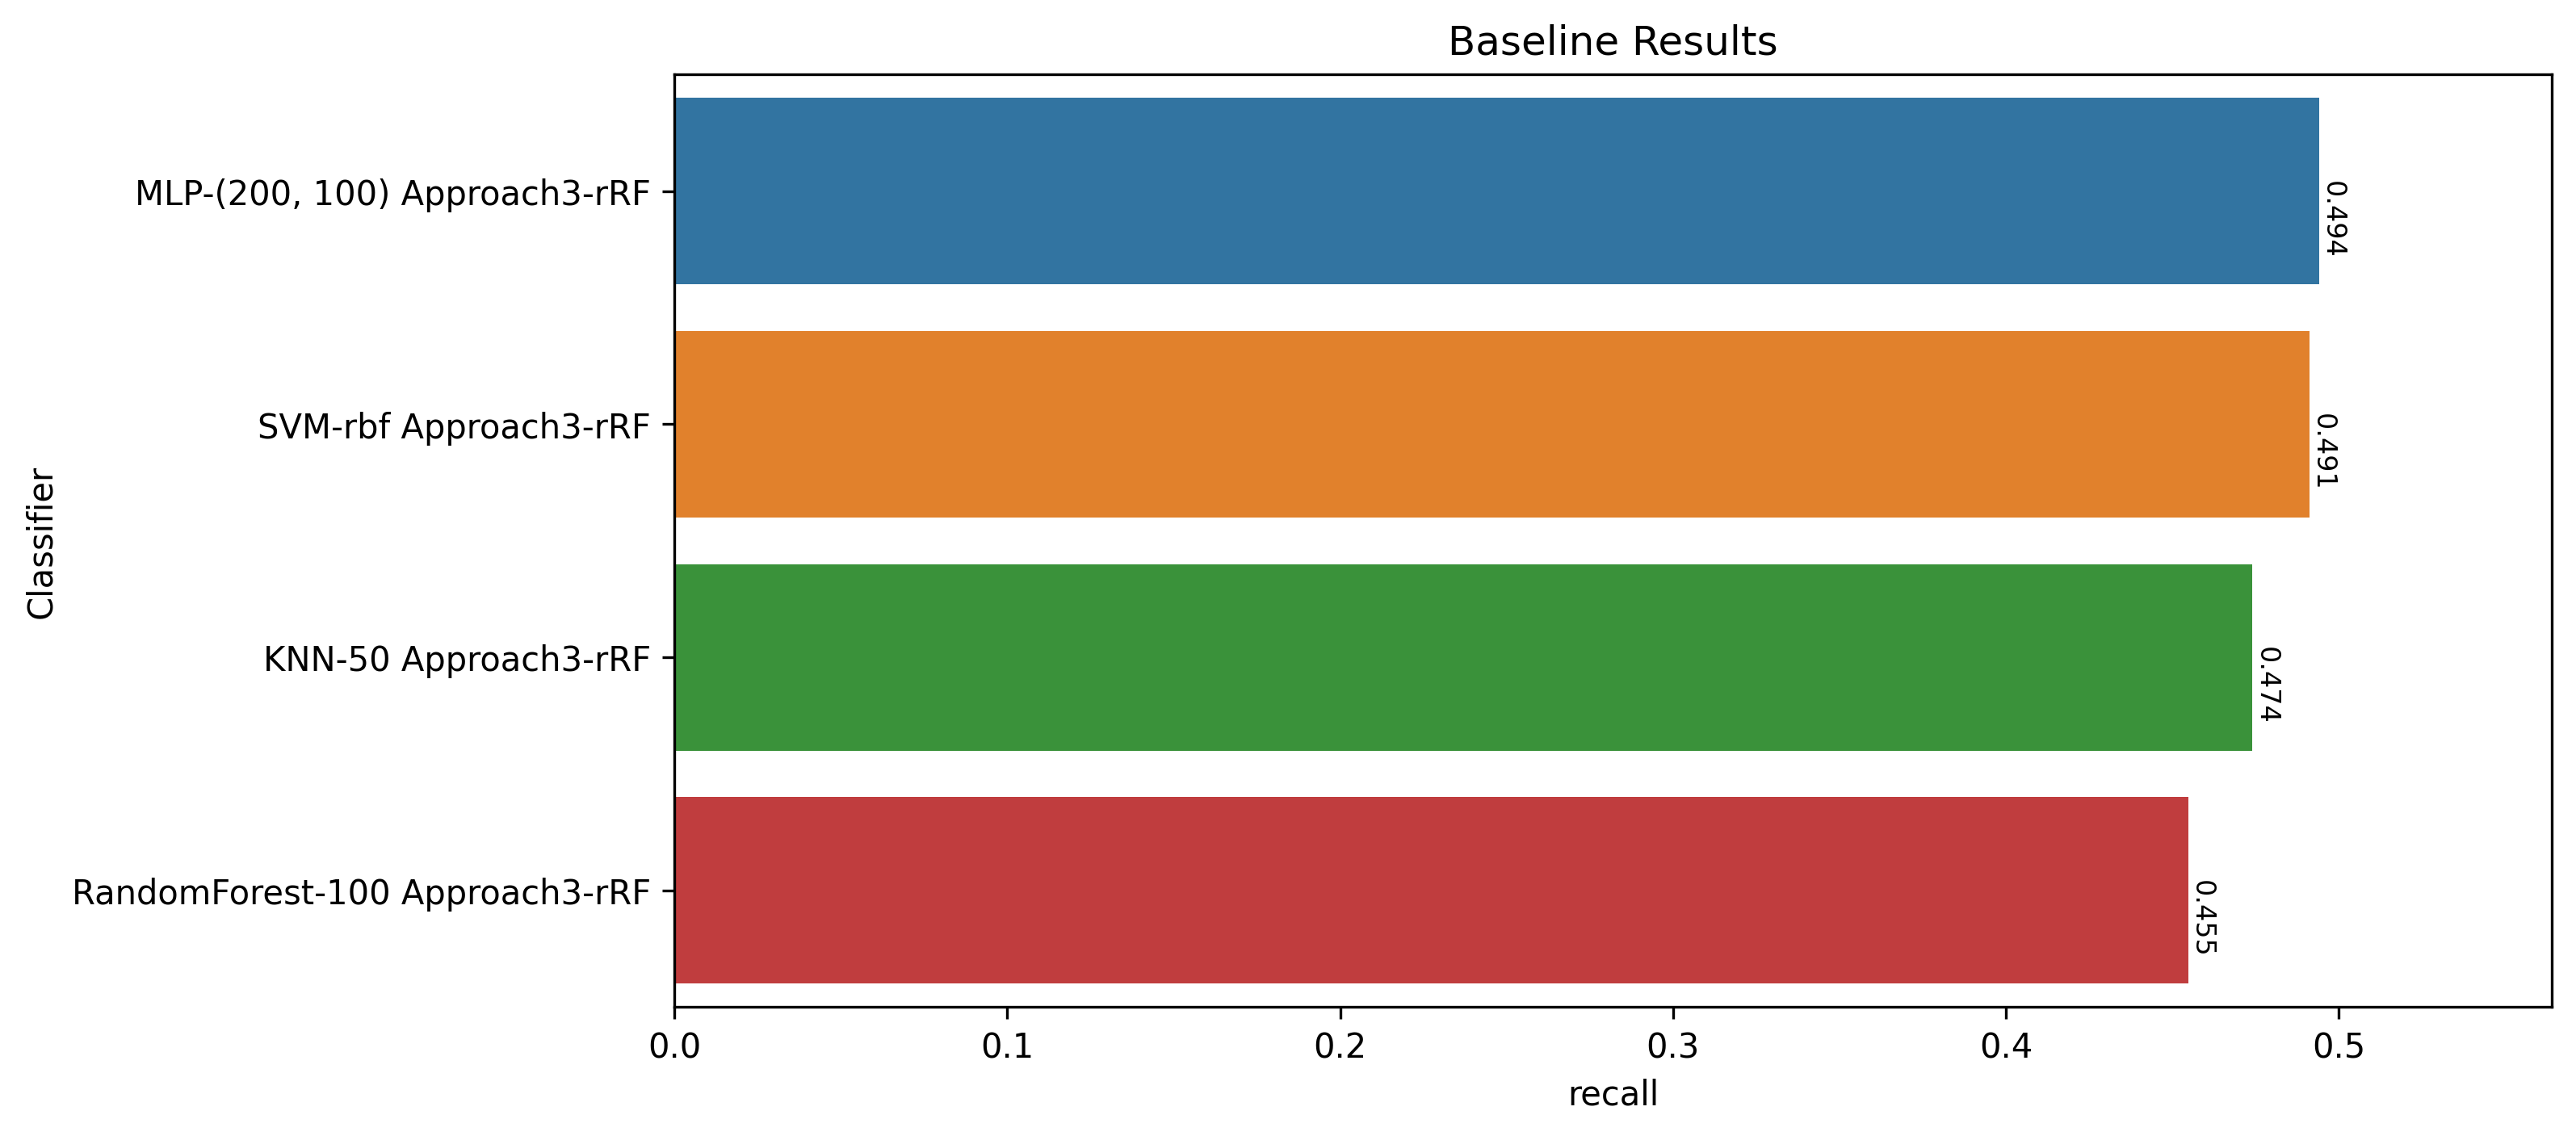

In [41]:
plot_results(proposed_results, 'recall')

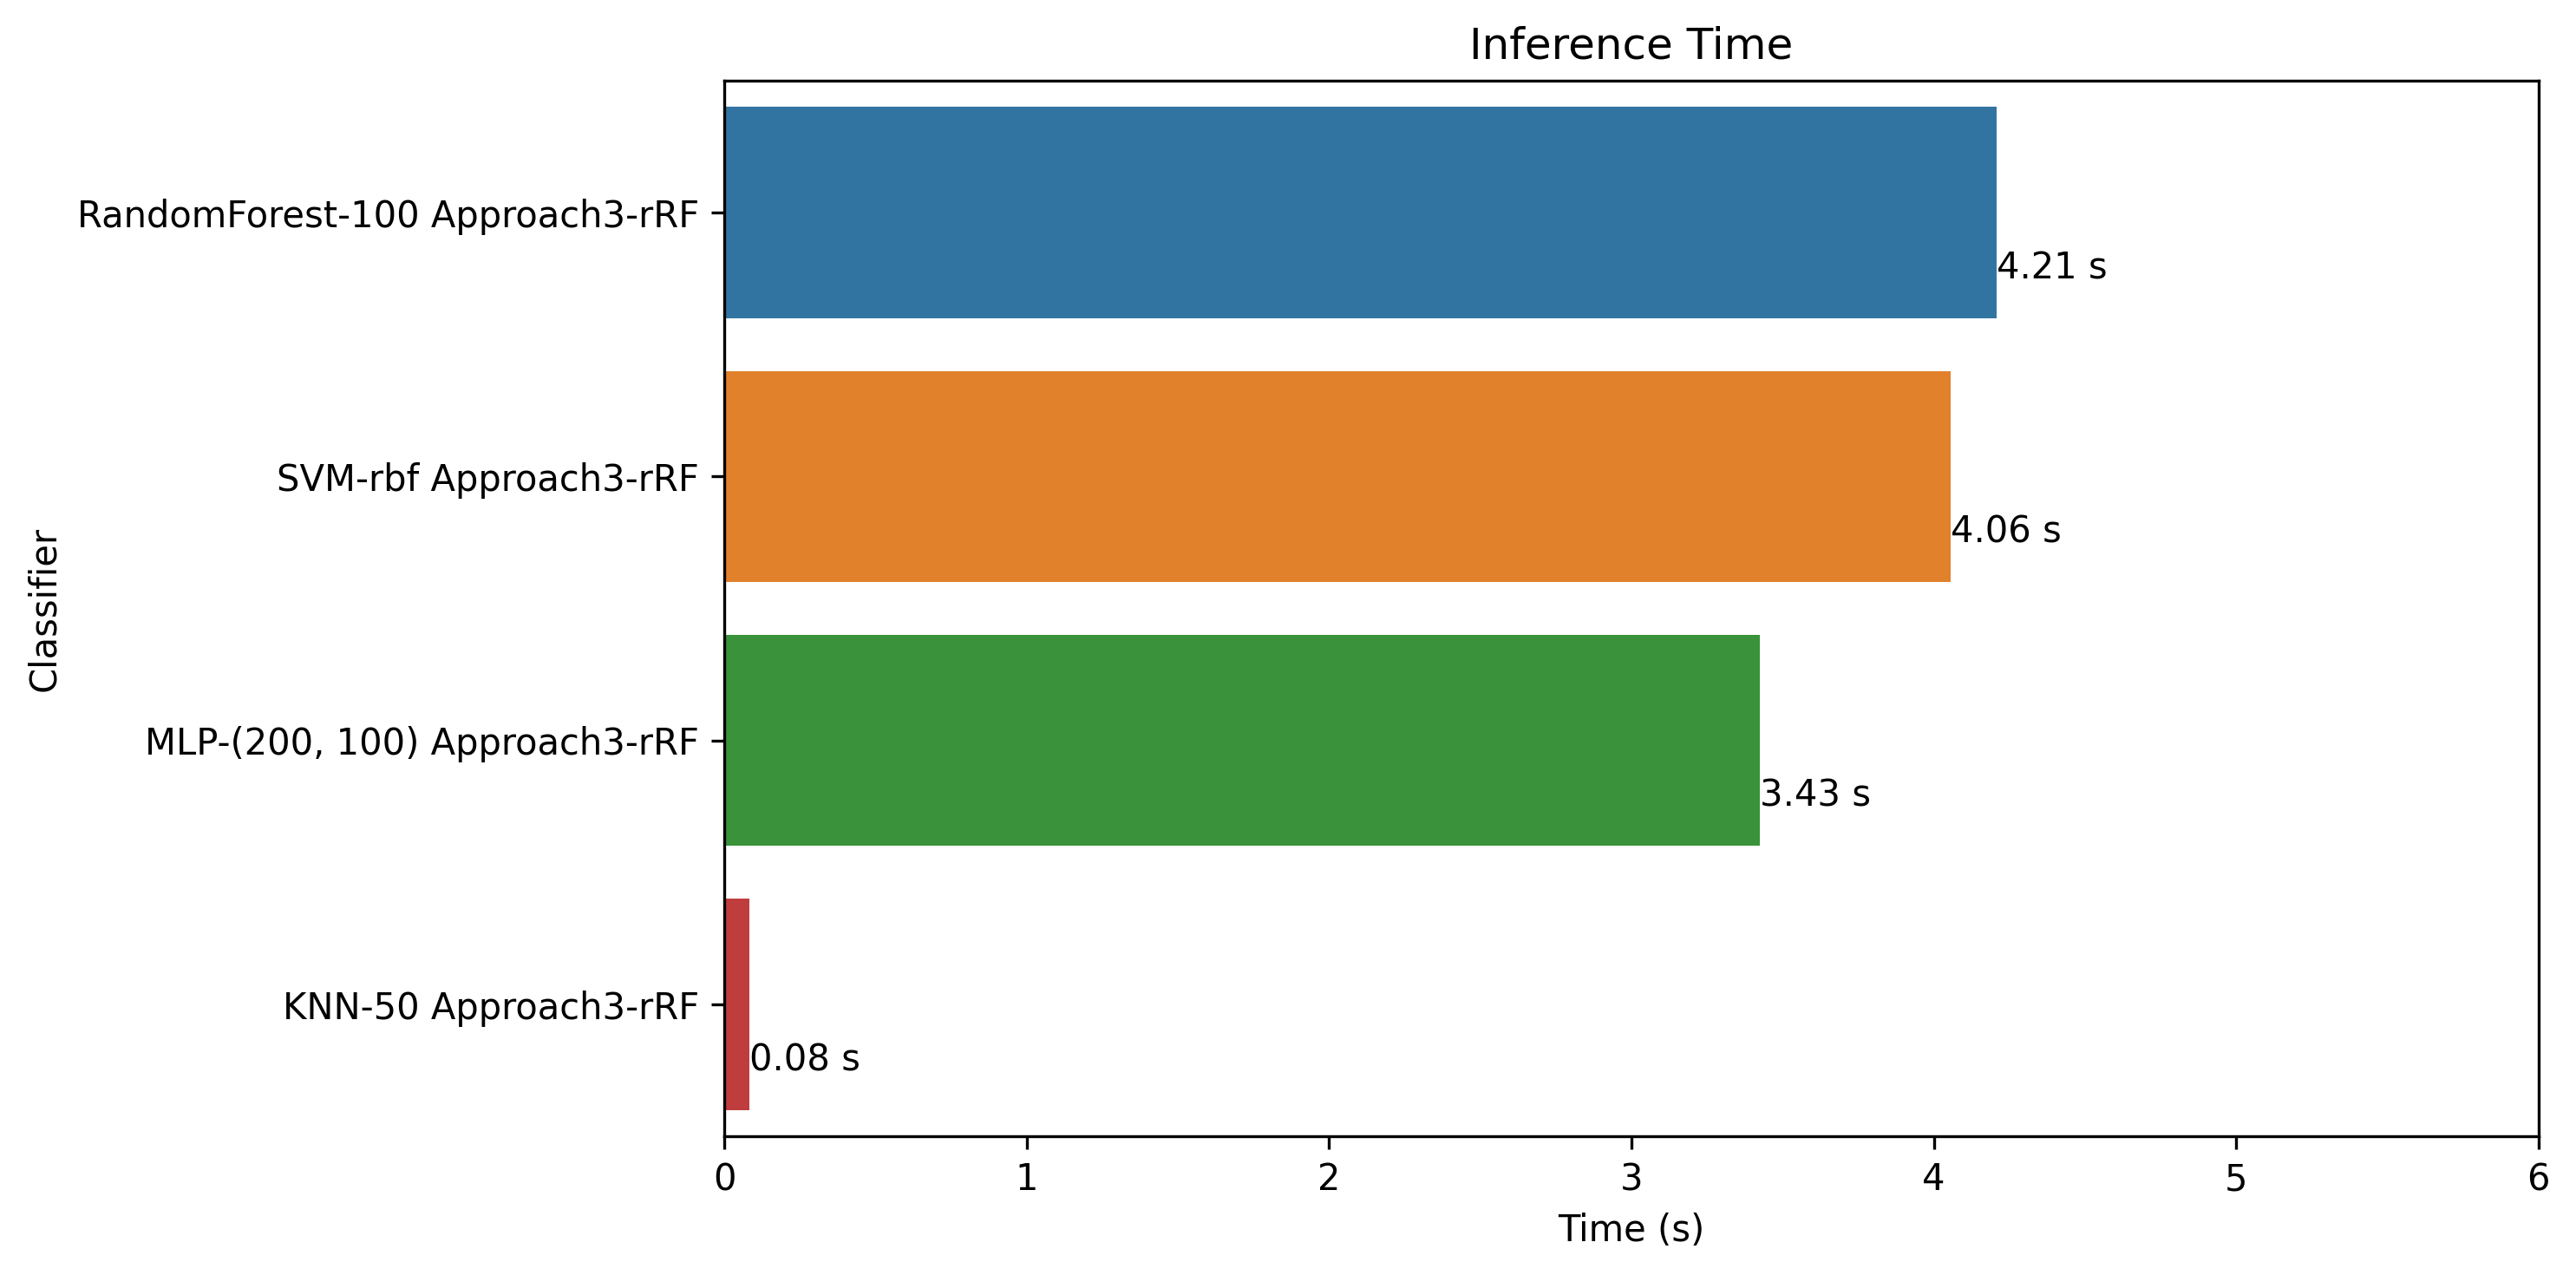

In [42]:
plot_inference_time(proposed_results, 'Inference Time', 'Time (s)')

In [43]:
memory["FEVER"] = X_train_reduced.nbytes

In [44]:
with open("proposed_results_FEVER.pkl", "wb") as pickle_file:
    pickle.dump(proposed_results, pickle_file)


***Aspect Sentiment Classification***

Load Data

In [45]:
df = pd.read_json('datasets/Aspect_Sentiment/train.json', orient="index")
df.rename(columns={'polarity': 'label'}, inplace=True)
df = df.sample(n=df.shape[0], random_state=2000, replace=False).reset_index(drop=True)
df_train, df_dev = np.split(df, [int(.9*len(df))])

df_test = pd.read_json('datasets/Aspect_Sentiment/test.json', orient="index")
df_test.rename(columns={'polarity': 'label'}, inplace=True)
df_test = df_test.sample(n=df_test.shape[0], random_state=2000, replace=False).reset_index(drop=True)

Generate SBERT embeddings

In [46]:
# X_train = model.encode(list(df_train.sentence))
# X_dev = model.encode(list(df_dev.sentence))
# X_test = model.encode(list(df_test.sentence))

# y_train = df_train["label"]
# y_dev = df_dev["label"]

In [47]:
# # save the embedding results
# pickle.dump(X_train, open("datasets/Aspect_Sentiment/embeddings/train_embeddings_originals.p","wb" ))
# pickle.dump(X_dev, open("datasets/Aspect_Sentiment/embeddings/dev_embeddings_originals.p", "wb"))
# pickle.dump(X_test, open("datasets/Aspect_Sentiment/embeddings/test_embeddings_originals.p", "wb"))

# # save the labels
# pickle.dump(y_train, open("datasets/Aspect_Sentiment/embeddings/train_labels_originals.p", "wb"))
# pickle.dump(y_dev, open("datasets/Aspect_Sentiment/embeddings/dev_labels_originals.p", "wb"))

In [48]:
# load the embeddings
X_train = pickle.load(open("datasets/Aspect_Sentiment/embeddings/train_embeddings_originals.p", "rb"))
X_dev = pickle.load(open("datasets/Aspect_Sentiment/embeddings/dev_embeddings_originals.p", "rb"))
X_test = pickle.load(open("datasets/Aspect_Sentiment/embeddings/test_embeddings_originals.p", "rb"))

# load the labels
y_train = pickle.load(open("datasets/Aspect_Sentiment/embeddings/train_labels_originals.p", "rb"))
y_dev = pickle.load(open("datasets/Aspect_Sentiment/embeddings/dev_labels_originals.p", "rb"))

Calculate TF-IDF Score

In [49]:
#Tokenize each senetence
df_train["list_of_words"] = 0

for i in range(len(df_train['sentence'])):
    sentence = df["sentence"][i].lower()
    sentence = re.sub(r'[^\w\s]', '', sentence)
 
    result = sentence.split()
    df_train["list_of_words"][i] = result
    

C:\Users\HP\AppData\Local\Temp\ipykernel_32168\3761323428.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["list_of_words"][i] = result


In [50]:
tf_matrix = create_tf_matrix(df_train["list_of_words"])
idf_matrix = create_idf_matrix(df_train["list_of_words"])

tf_idf_matrix = create_tf_idf_matrix(tf_matrix, idf_matrix)

In [51]:
df_train = calculate_sentence_scores(tf_idf_matrix, df_train)

C:\Users\HP\AppData\Local\Temp\ipykernel_32168\1346757543.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["tf_idf_score"][sentence] = sum_of_tf_idf/len_of_sentence


Cluster Embeddings on Similarity and Dimensionality Reduction

In [52]:
embeddings, y_train_reduced = dimensionality_reduction_with_clustering(X_train, y_train, tf_idf_matrix)

X_train_reduced = np.array(embeddings)
y_train_reduced = np.array(y_train_reduced)

Classification

In [53]:
proposed_results= {}
run_classifiers(X_train_reduced, y_train_reduced, X_dev, y_dev, results=proposed_results, suffix=f'Approach3-rRF', **configurations)

{'SVM-rbf Approach3-rRF': {'negative': {'precision': 0.75,
   'recall': 0.9113924050632911,
   'f1-score': 0.8228571428571428,
   'support': 79},
  'neutral': {'precision': 0.4722222222222222,
   'recall': 0.3617021276595745,
   'f1-score': 0.40963855421686746,
   'support': 47},
  'positive': {'precision': 0.8235294117647058,
   'recall': 0.7692307692307693,
   'f1-score': 0.7954545454545454,
   'support': 91},
  'accuracy': 0.7327188940092166,
  'macro avg': {'precision': 0.681917211328976,
   'recall': 0.6807751006512116,
   'f1-score': 0.6759834141761852,
   'support': 217},
  'weighted avg': {'precision': 0.7206710641245746,
   'recall': 0.7327188940092166,
   'f1-score': 0.721866774056547,
   'support': 217},
  'infer_time': 0.2546813488006592},
 'MLP-(200, 100) Approach3-rRF': {'negative': {'precision': 0.7701149425287356,
   'recall': 0.8481012658227848,
   'f1-score': 0.8072289156626505,
   'support': 79},
  'neutral': {'precision': 0.4722222222222222,
   'recall': 0.361702127

Plot Results

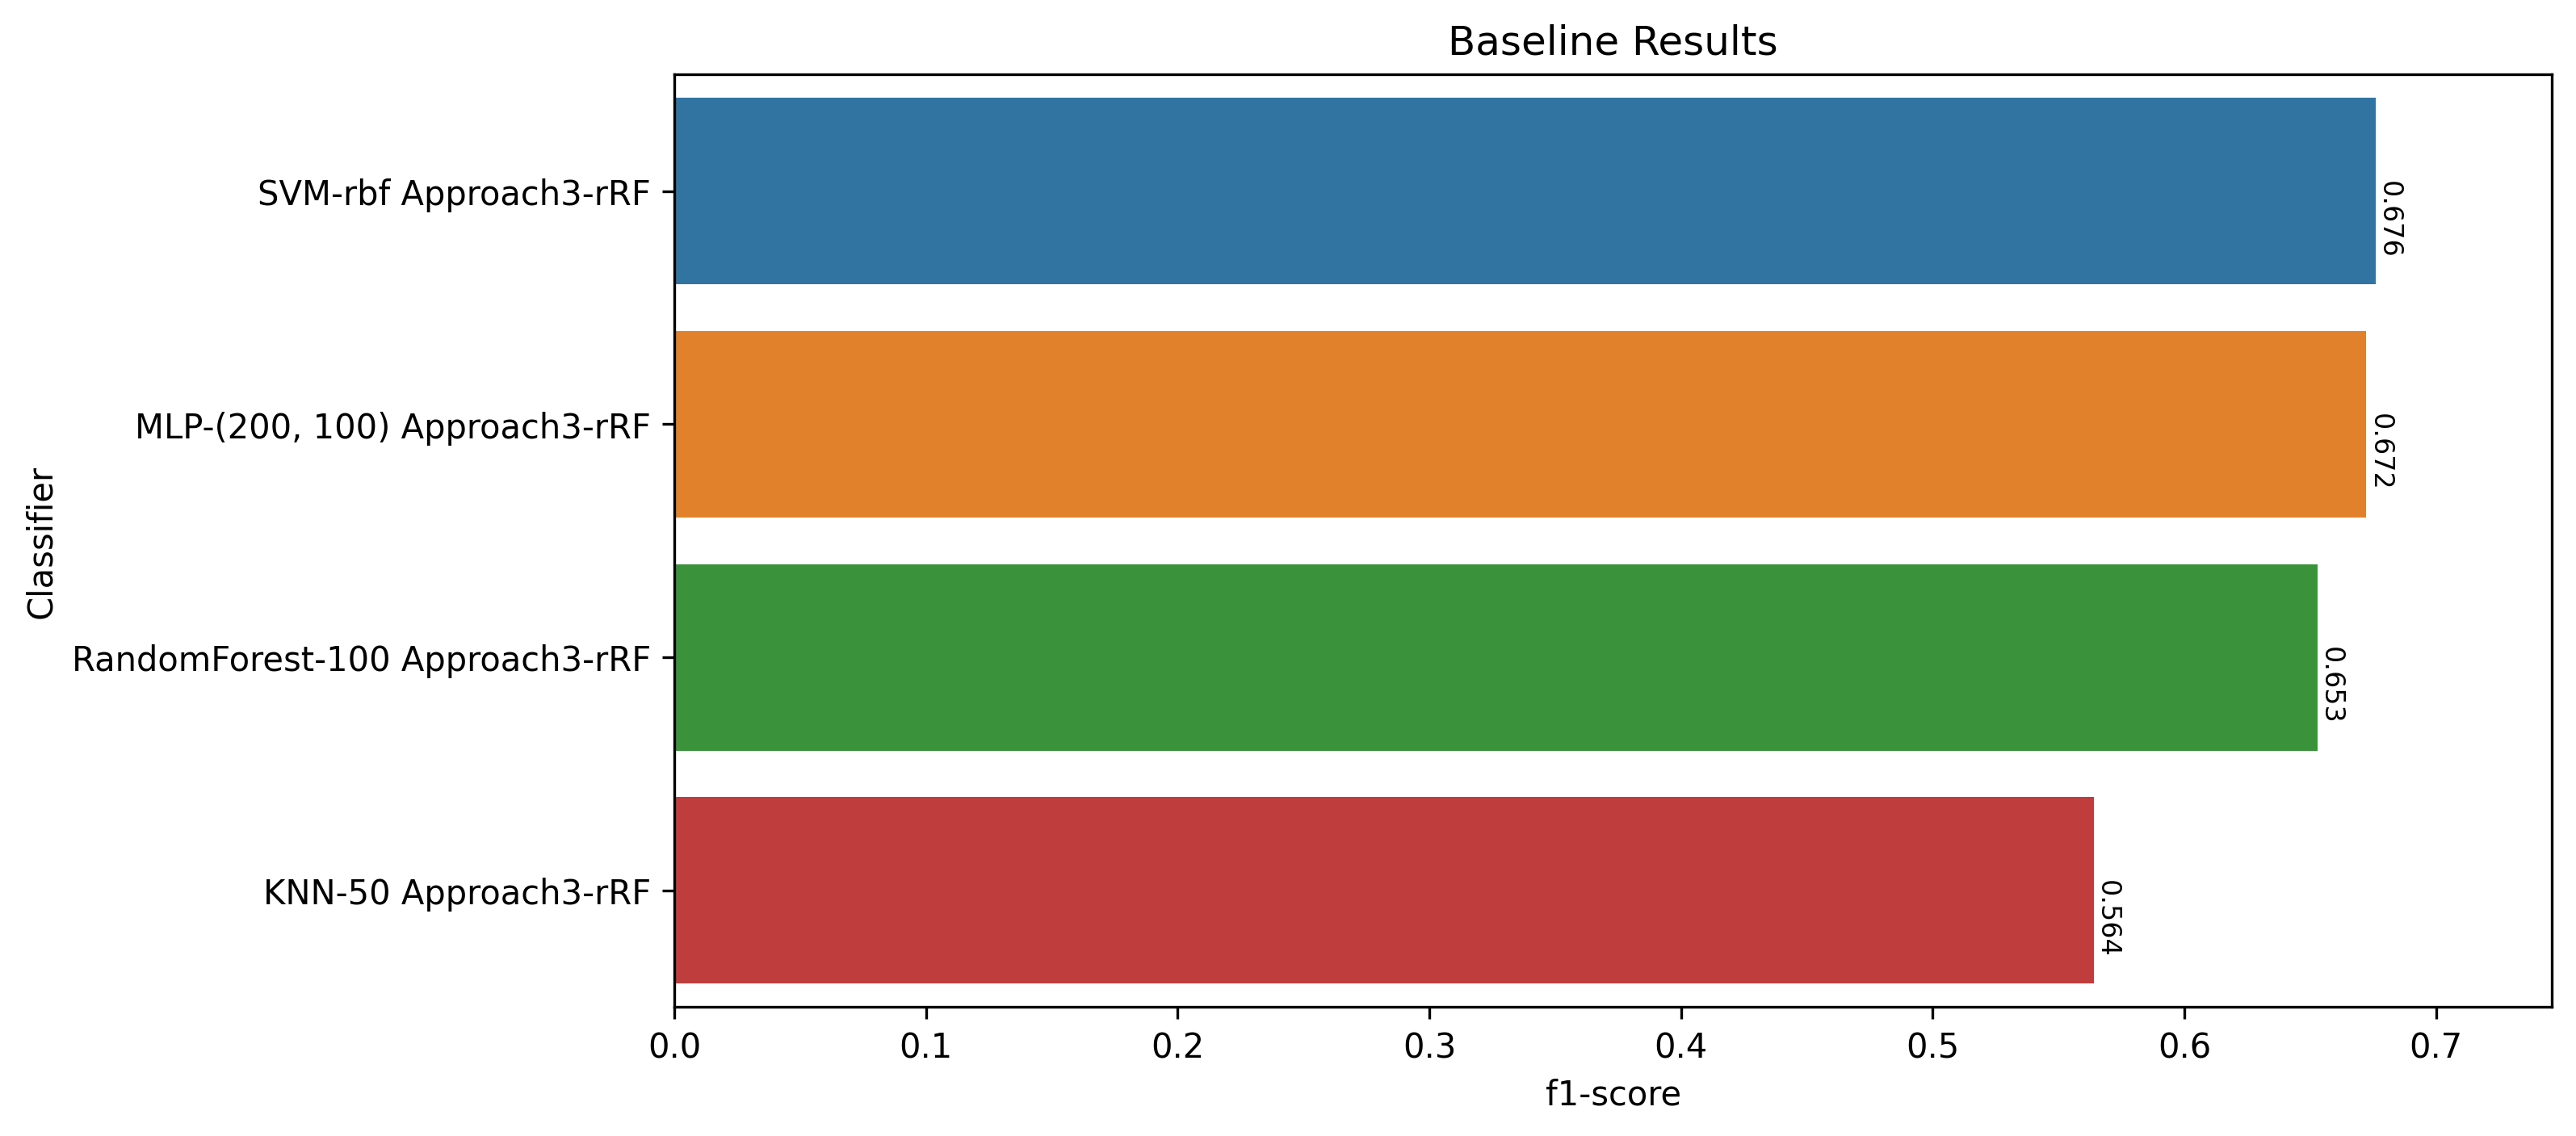

In [54]:
plot_results(proposed_results, 'f1-score')

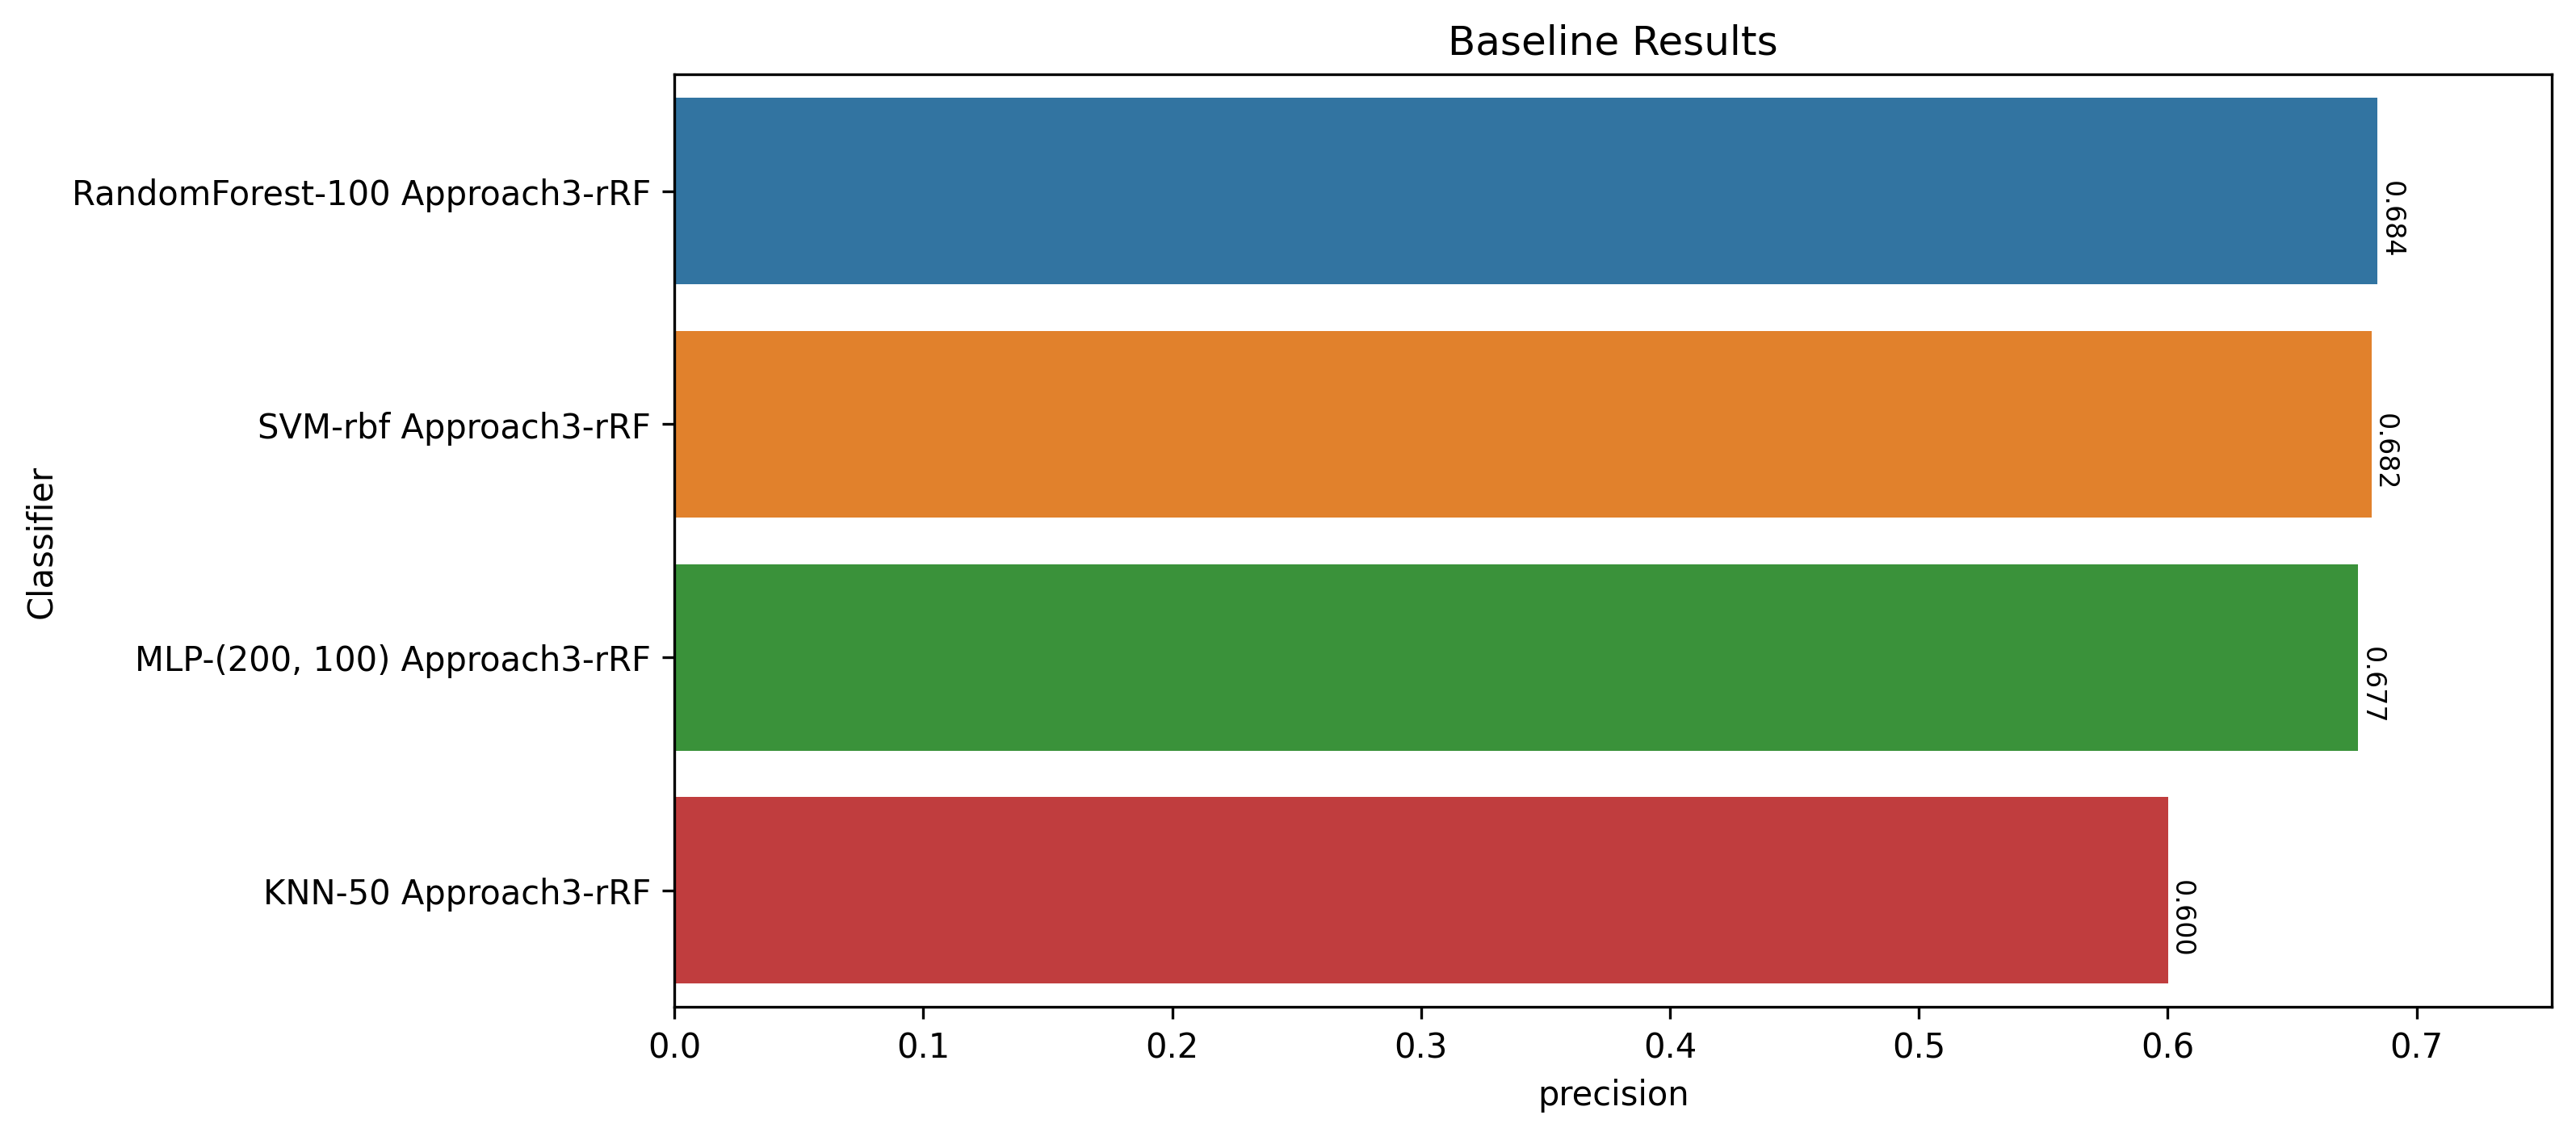

In [55]:
plot_results(proposed_results, 'precision')

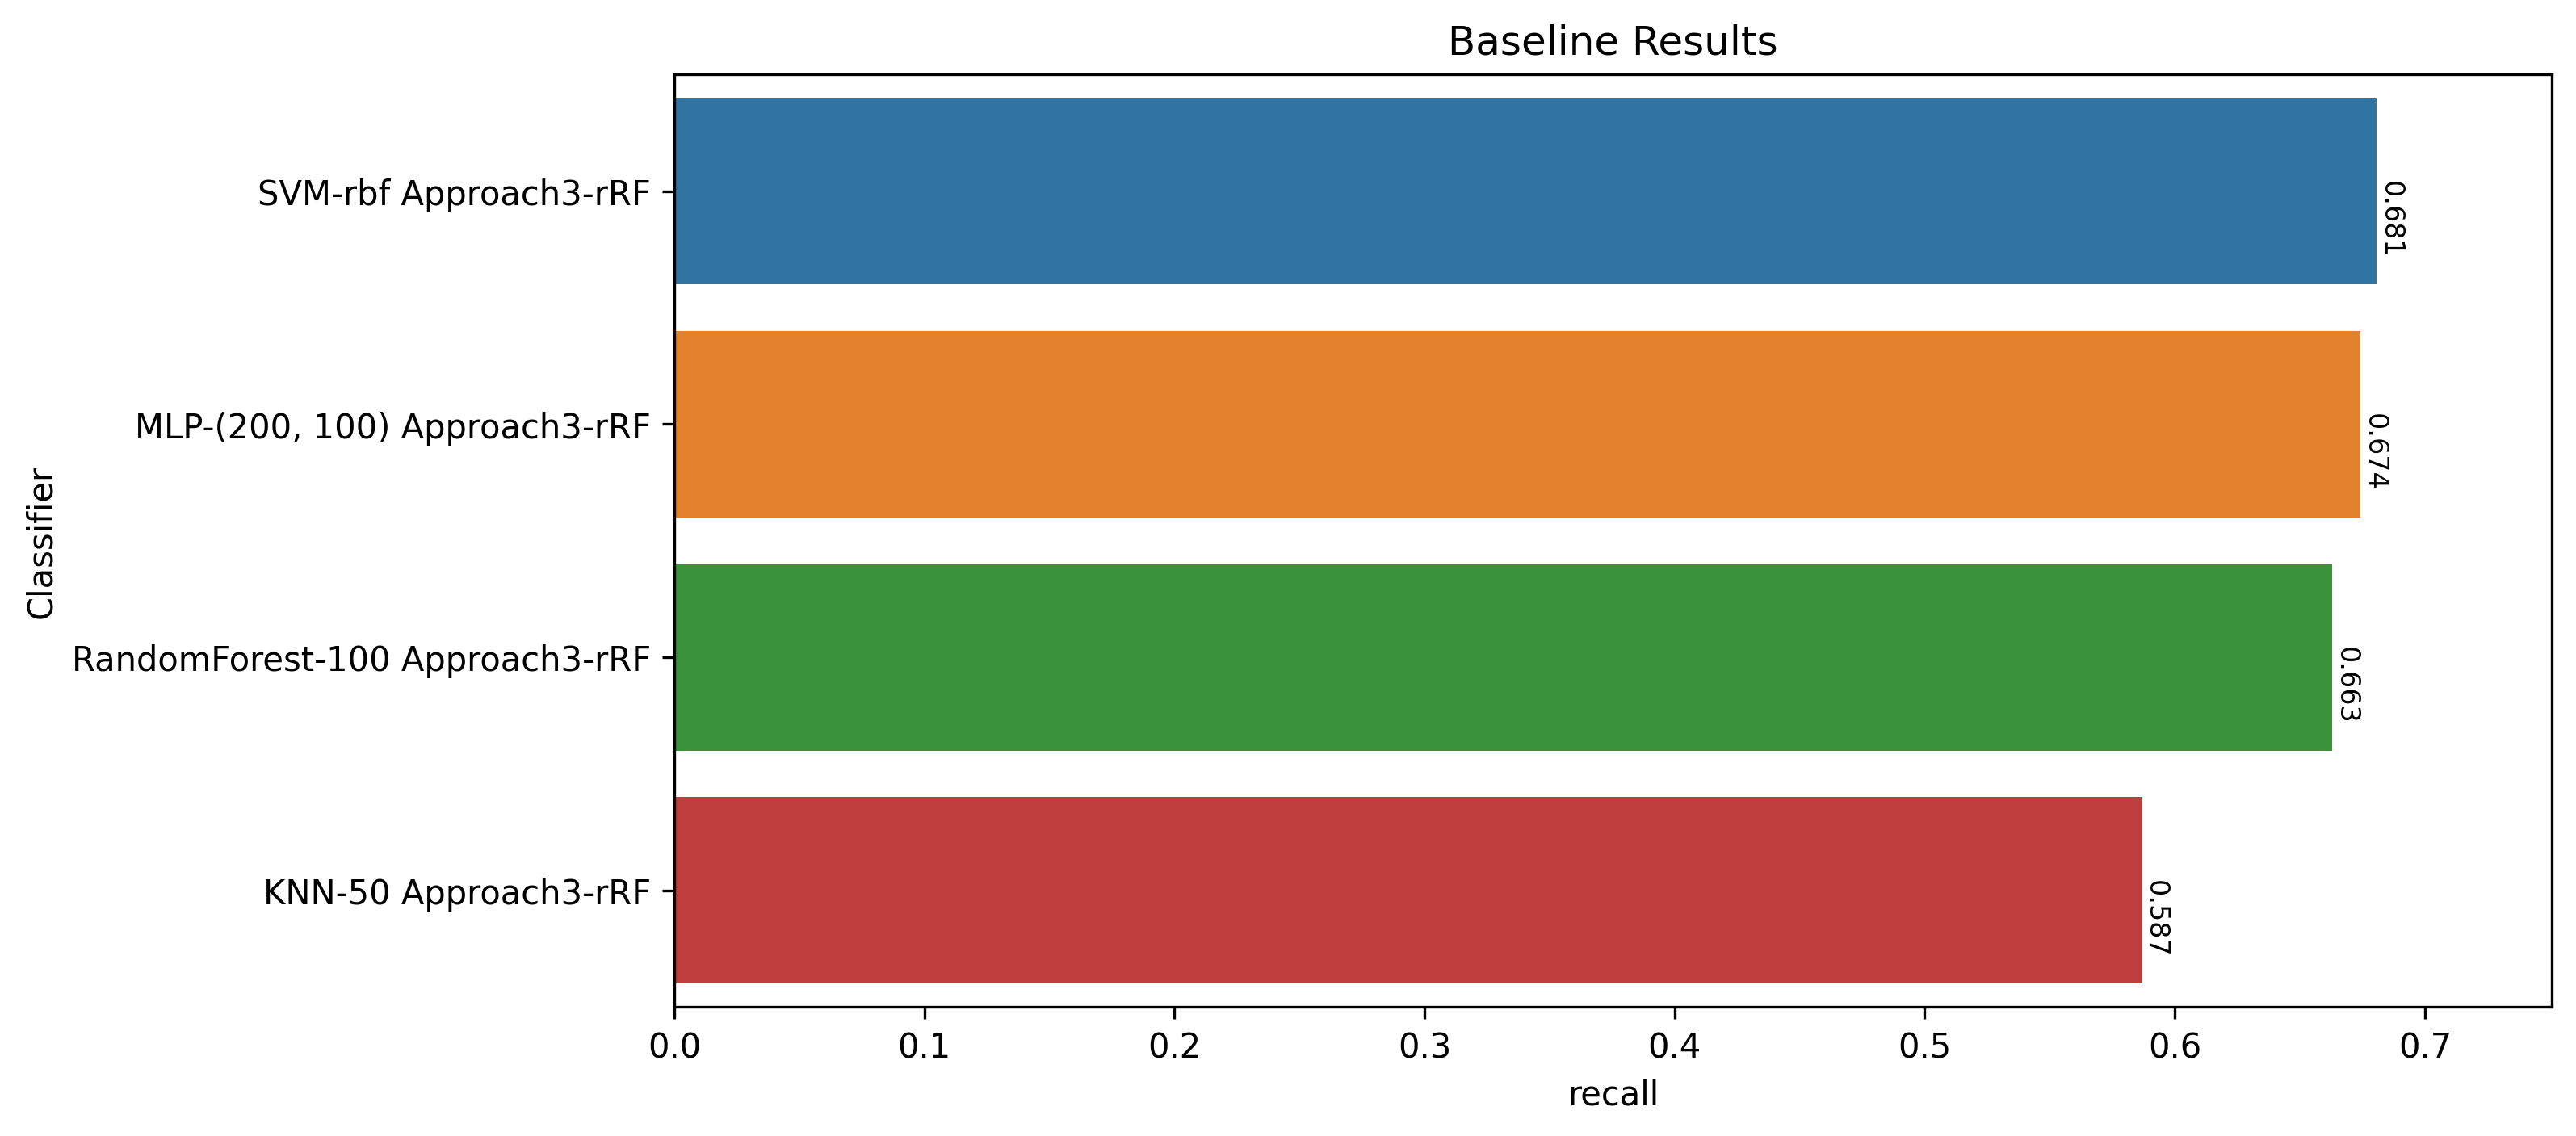

In [56]:
plot_results(proposed_results, 'recall')

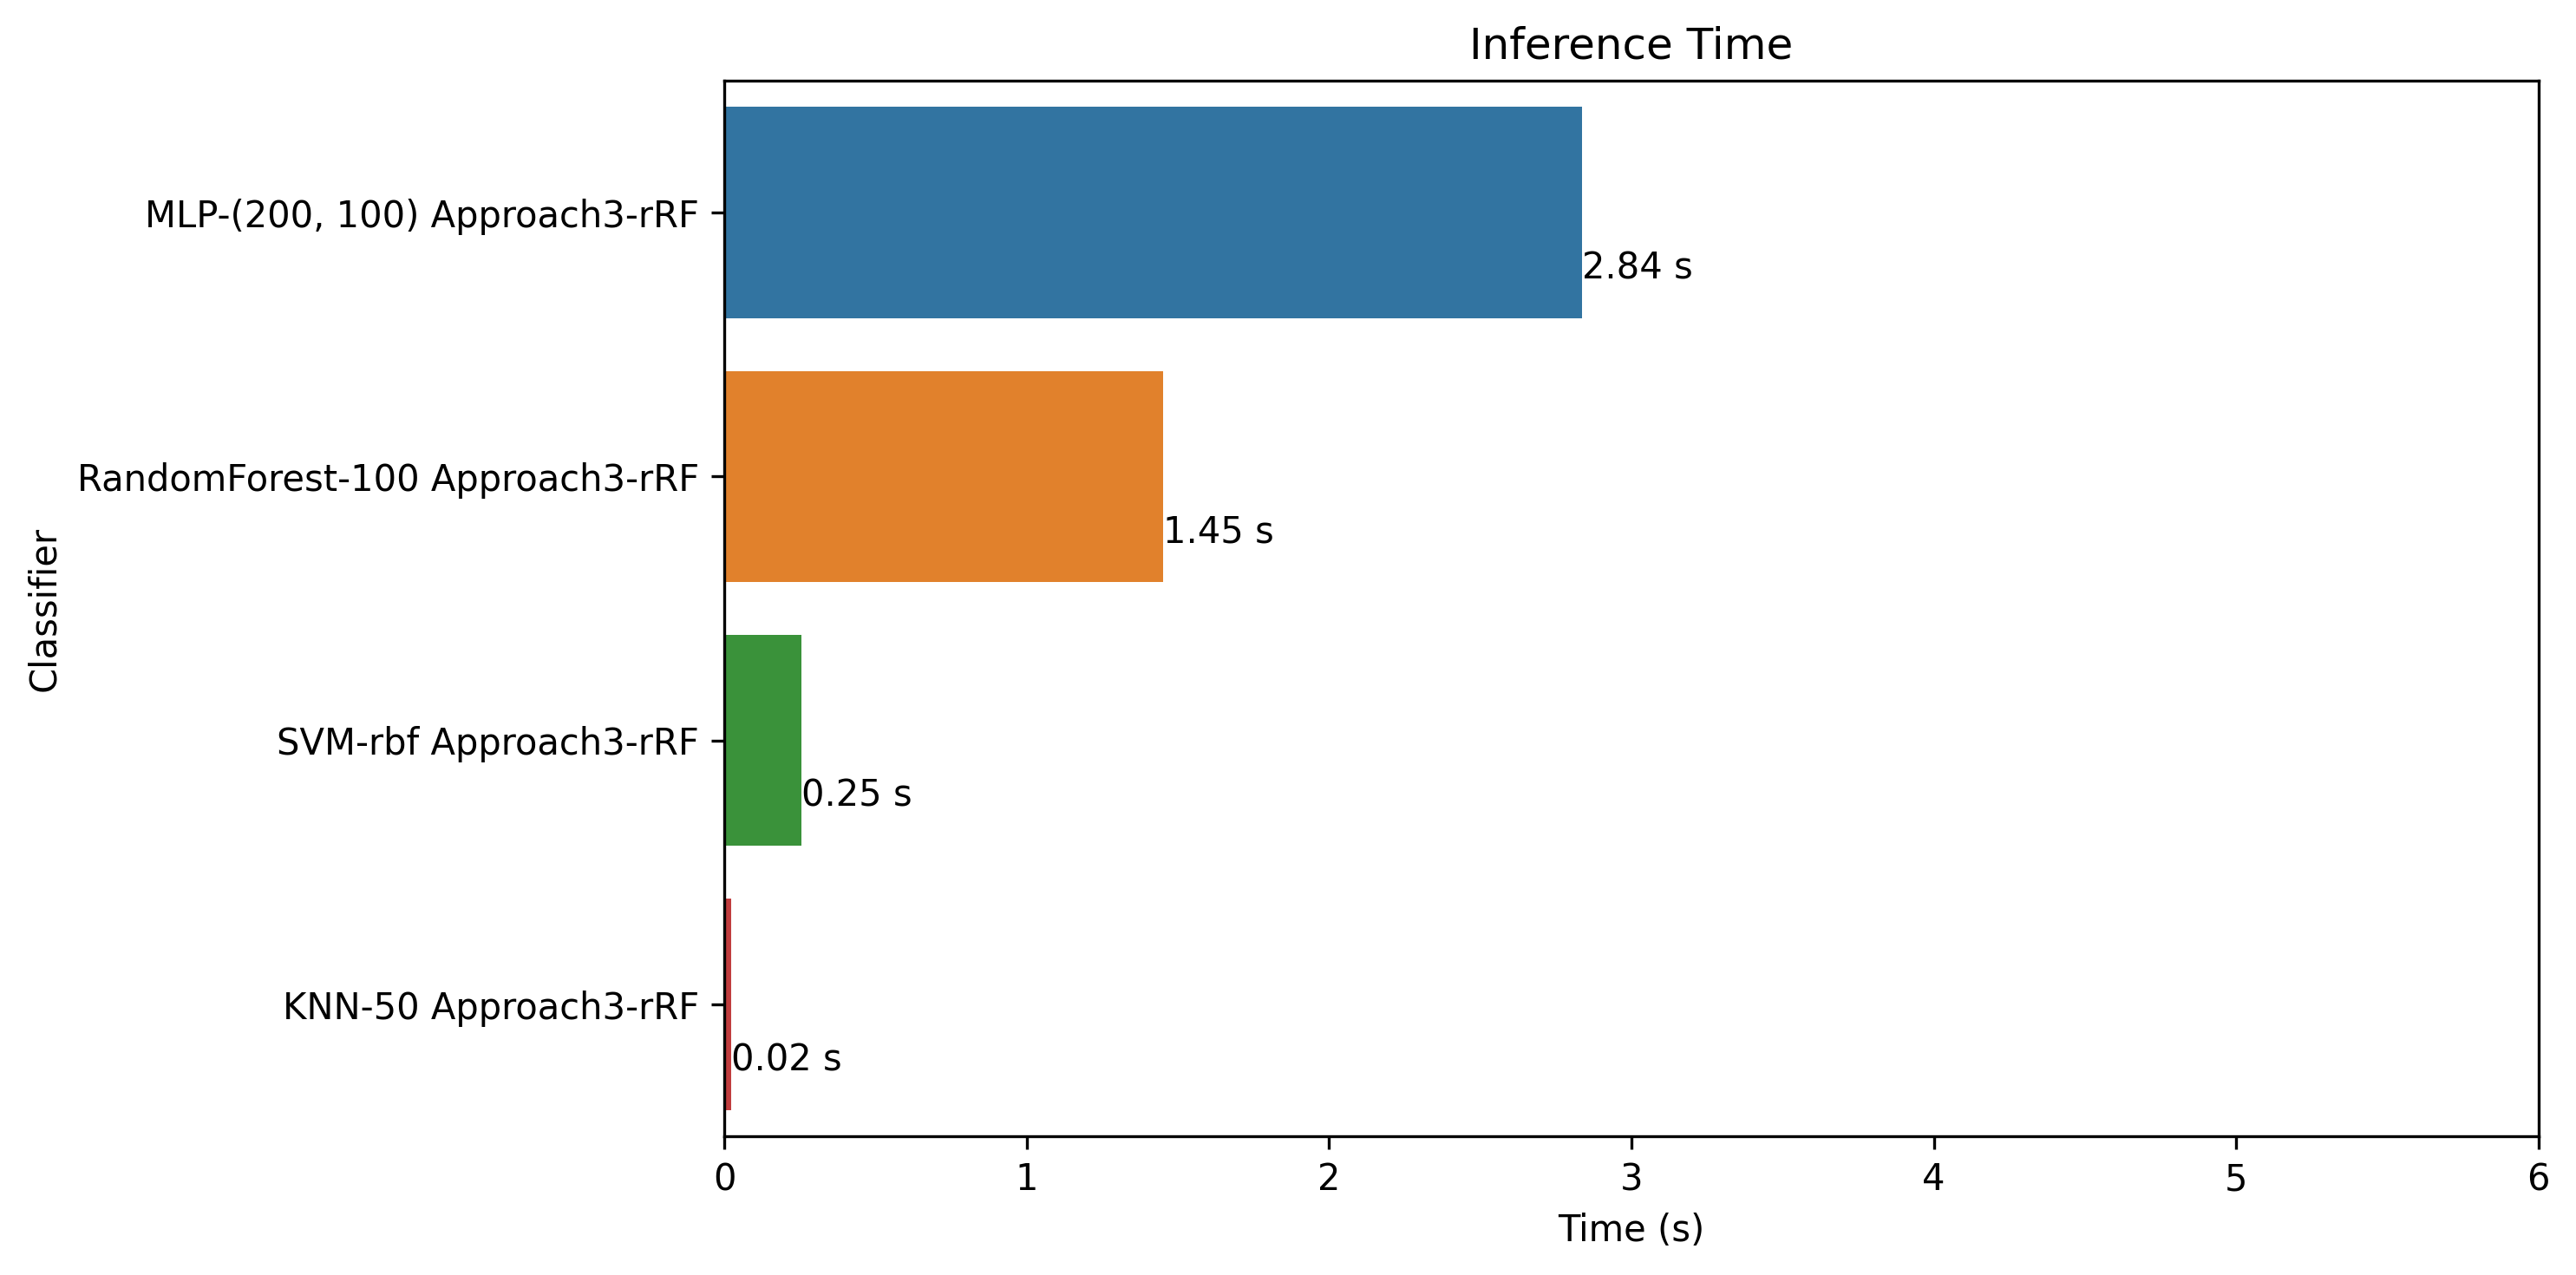

In [57]:
plot_inference_time(proposed_results, 'Inference Time', 'Time (s)')

In [58]:
memory["AspectSentimentAnalysis"] = X_train_reduced.nbytes

In [59]:
with open("proposed_results_AspectSentimentAnalysis.pkl", "wb") as pickle_file:
    pickle.dump(proposed_results, pickle_file)


In [60]:
with open("size_all_datasets.pkl", "wb") as pickle_file:
    pickle.dump(memory, pickle_file)
